# Loading data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp "drive/My Drive/preprocessing_tools.py" .

In [5]:
!pip install razdel
!pip install pymorphy2

     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 8.2MB 9.3MB/s 


In [6]:
!cp "drive/My Drive/stopwords.txt" .

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import probplot
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression
from scipy import sparse
import lightgbm as lgb
import preprocessing_tools as pr
import plotly
import cufflinks as cf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import gc

color = sns.color_palette()

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

%matplotlib inline

In [8]:
raw_data = pd.read_csv('/content/drive/My Drive/clear_dataset.csv', index_col=0, parse_dates=True, encoding='UTF-8')
raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212699 entries, 2006-10-24 20:49:00 to 2019-06-26 08:15:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tittle  212699 non-null  object
 1   text    212699 non-null  object
 2   rate    212699 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.5+ MB


,tittle,text,rate
date,,,
2006-10-24 20:49:00,В США и России размещено больше всего сайтов с...,Организация Internet Watch Foundation в ходе ...,0
2006-11-30 12:07:00,«Цифровой раздел» между поколениями увеличивается,"21% американских родителей уверены в том, что...",-2
2006-09-05 08:32:00,Результаты Yahoo Answers вошли в основную выда...,Флагман социального поиска в интернете Yahoo ...,0
2006-07-01 21:45:00,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,0
2007-01-19 11:14:00,Внутренний голос в RSS,У меня вот какая бяка постоянно вылезает. Есл...,0


# 1. Preprocessing

In [ ]:
# проверка пропущенных значений (в данном случае их нет)
print('Shape: ', raw_data.shape)
print('Shape after dropping nan values: ', raw_data.dropna().shape)
columns = ['title', 'text', 'rate']
raw_data.columns = columns

Shape:  (212699, 3)
Shape after dropping nan values:  (212699, 3)


In [ ]:
raw_data.tail()

,title,text,rate
date,,,
2019-06-27 07:38:00,Продакт-менеджер здорового человека,Каких менеджеров любят дизайнеры в продуктовы...,3
2019-06-26 07:51:00,"EA заявила, что лутбоксы — это «довольно этичн...",На заседании комитета парламента Великобрит...,13
2019-06-27 08:09:00,Дайджест событий для HR-специалистов в сфере I...,Июль — самое время запланировать путешеств...,11
2019-06-26 08:04:00,Минимальная установка CentOS/Fedora/RedHat,"Не сомневаюсь, что благородные доны — админис...",7
2019-06-26 08:15:00,Счетная палата РФ открывает свои исходные коды,Счетная палата выходит на новый уровень пр...,16


## 1.1. Feature engineering



In [13]:
%%time
raw_data['weekday'] = raw_data.index.weekday
raw_data['year'] = raw_data.index.year
raw_data['month'] = raw_data.index.month
raw_data['hour'] = raw_data.index.hour
raw_data['text_lenght'] = raw_data.text.apply(len)

CPU times: user 523 ms, sys: 28.5 ms, total: 552 ms
Wall time: 563 ms


In [ ]:
raw_data.head()

,title,text,rate,weekday,year,month,hour,text_lenght
date,,,,,,,,
2006-10-24 20:49:00,В США и России размещено больше всего сайтов с...,Организация Internet Watch Foundation в ходе ...,0,1,2006,10,20,772
2006-11-30 12:07:00,«Цифровой раздел» между поколениями увеличивается,"21% американских родителей уверены в том, что...",-2,3,2006,11,12,658
2006-09-05 08:32:00,Результаты Yahoo Answers вошли в основную выда...,Флагман социального поиска в интернете Yahoo ...,0,1,2006,9,8,564
2006-07-01 21:45:00,«Артон консалтинг» исследовала контекстную рек...,Компания «Артон консалтинг» опубликовала иссл...,0,5,2006,7,21,1524
2007-01-19 11:14:00,Внутренний голос в RSS,У меня вот какая бяка постоянно вылезает. Есл...,0,4,2007,1,11,255


# 2. Exploratory data analysis


## 2.1. Target Variable

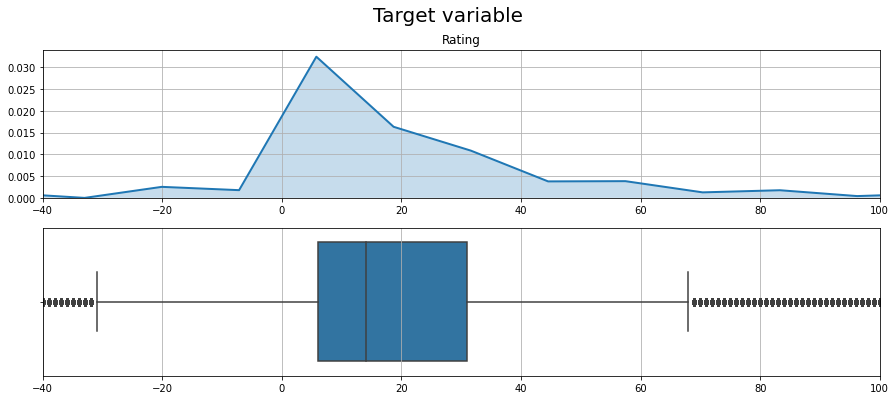

In [ ]:
plt.figure(figsize=(15,6))
plt.suptitle("Target variable",fontsize=20)
gridspec.GridSpec(1,2)

plt.subplot2grid((2,2),(0,0), colspan = 2)
plt.xlim(-40, 100)
sns.distplot(raw_data.rate.values, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.grid(True)
plt.title("Rating")

plt.subplot2grid((2,2),(1,0), colspan = 2)
plt.xlim(-40, 100)
plt.grid(True)
sns.boxplot(raw_data.rate.values)


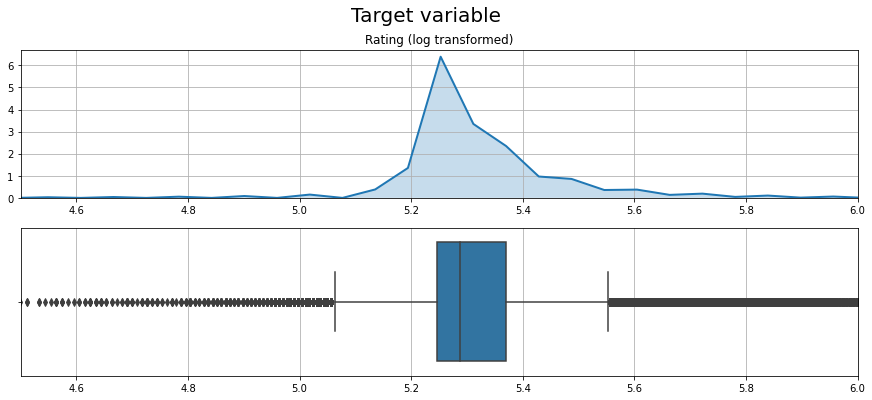

In [ ]:
min_rate = raw_data.rate.values.min()
plt.figure(figsize=(15,6))
plt.suptitle("Target variable",fontsize=20)
gridspec.GridSpec(2,2)

plt.subplot2grid((2,2),(0,0), colspan = 2)
plt.xlim(4.5, 6)
sns.distplot(np.log1p(raw_data.rate.values + abs(min_rate)), hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.grid(True)
plt.title("Rating (log transformed)")

plt.subplot2grid((2,2),(1,0), colspan = 2)
plt.xlim(4.5, 6)
plt.grid(True)
sns.boxplot(np.log1p(raw_data.rate.values + abs(min_rate)))


##2.2. Time series features

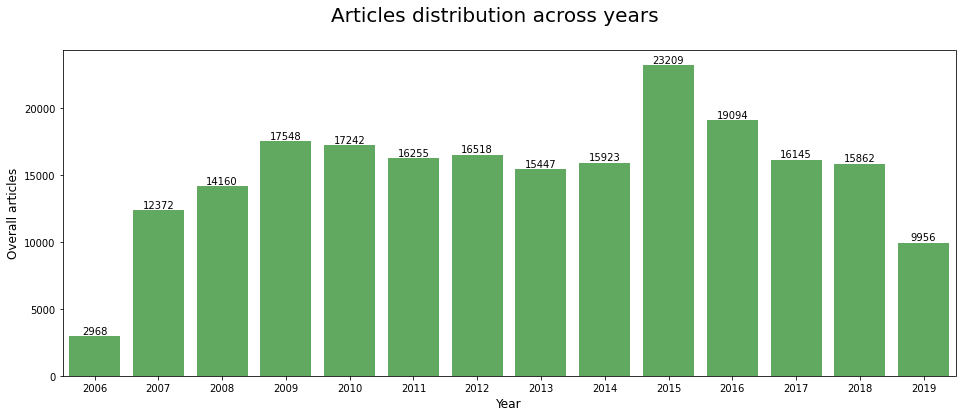

In [ ]:
plt.figure(figsize=(16,6))
plt.suptitle("Articles distribution across years",fontsize=20)

ax1 = sns.countplot(x='year', data=raw_data, alpha=0.8, color=color[2])
plt.ylabel('Overall articles', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [14]:
subsample = raw_data[raw_data.year >= 2016]

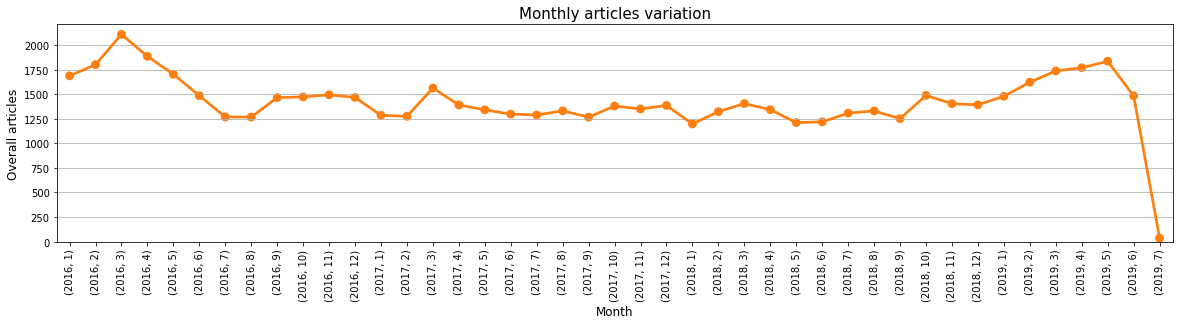

In [ ]:
temp=subsample.groupby(['year','month'])['hour'].count()
plt.figure(figsize=(20,4))
sns.pointplot(temp.index,temp.values, alpha=0.8, color=color[1])
plt.grid(True, axis='y')
plt.ylim(0)
plt.ylabel('Overall articles', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly articles variation', fontsize=15)
plt.xticks(rotation='vertical');

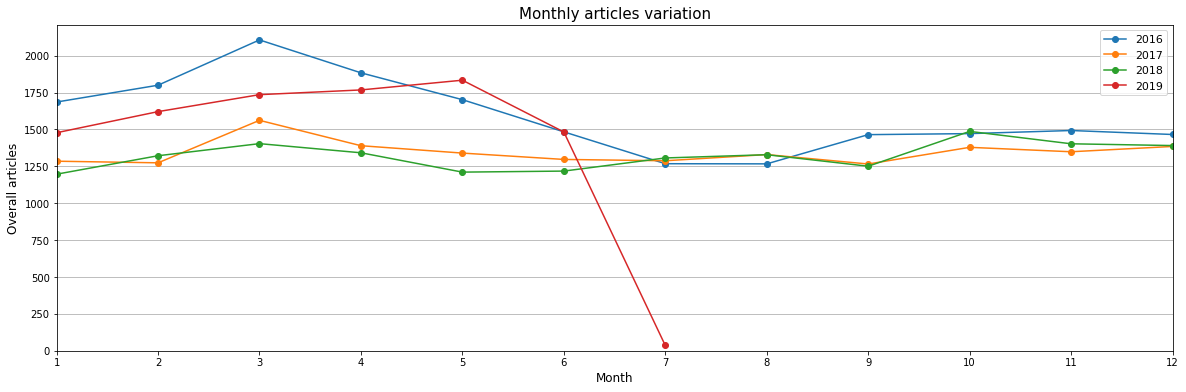

In [ ]:
temp=subsample.groupby(['year','month']).aggregate({'hour':np.size,'year':np.min,'month':np.min})
temp.reset_index(drop=True, inplace=True)
plt.figure(figsize=(20,6))
plt.plot(range(1,13),temp.iloc[0:12,0],label="2016", marker='o')
plt.plot(range(1,13),temp.iloc[12:24,0],label="2017", marker='o')
plt.plot(range(1,13),temp.iloc[24:36,0],label="2018", marker='o')
plt.plot(range(1,8),temp.iloc[36:43,0],label="2019", marker='o')
plt.grid(True, axis='y')
plt.ylim(0)
plt.ylabel('Overall articles', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly articles variation', fontsize=15)
plt.xticks(np.arange(1, 13, 1.0))
plt.xlim(1, 12)
plt.legend(loc='upper right', fontsize=11)
plt.xticks(rotation='horizontal');

Как можно видеть, наибольшее число статей публикуется в первой половине года.


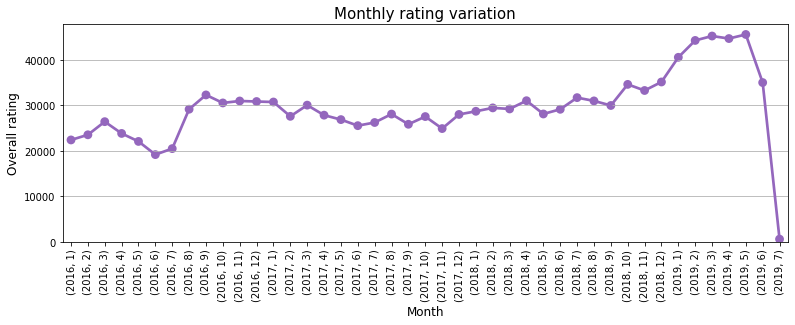

In [ ]:
temp=subsample.groupby(['year','month'])['rate'].sum()
plt.figure(figsize=(13,4))
sns.pointplot(temp.index,temp.values, alpha=0.8, color=color[4],)
plt.grid(True, axis='y')
plt.ylim(0)
plt.ylabel('Overall rating', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title('Monthly rating variation', fontsize=15)
plt.xticks(rotation='vertical');

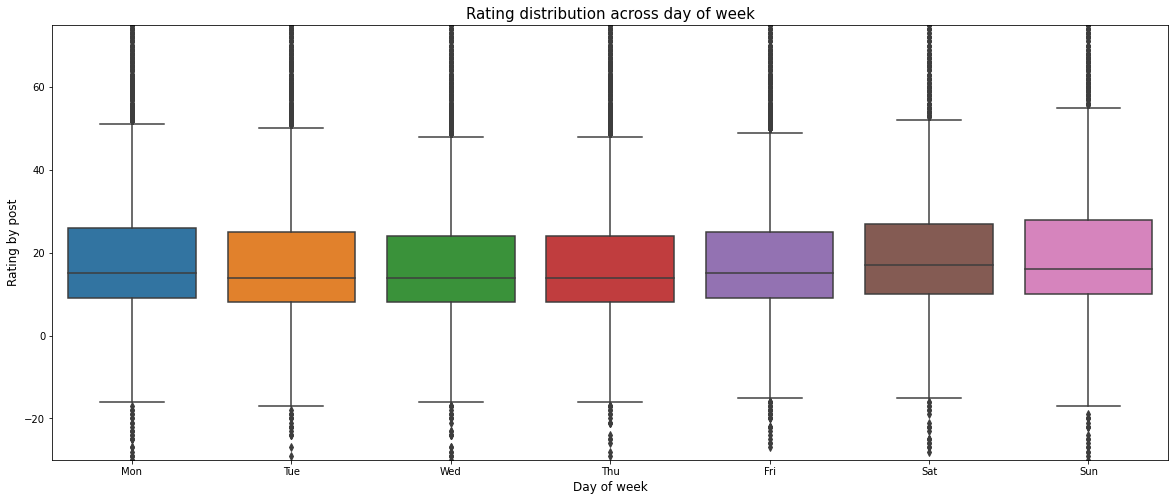

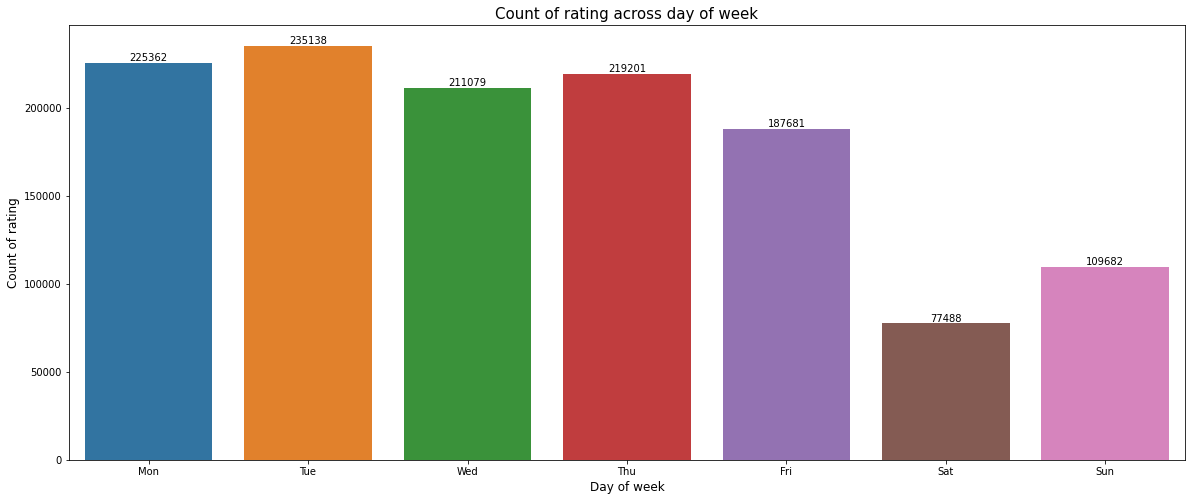

In [ ]:
plt.figure(figsize=(20,8))

#plt.subplot(121)
ax1 = sns.boxplot(y='rate',x='weekday', data=subsample)
plt.ylim(-30,75)
plt.ylabel('Rating by post', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Rating distribution across day of week', fontsize=15)
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])


plt.figure(figsize=(20,8))
#plt.subplot(122)
temp = subsample.groupby('weekday')['rate'].sum()
ax2 = sns.barplot(temp.index,np.round(temp.values))
plt.ylabel('Count of rating', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Count of rating across day of week', fontsize=15)
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{}'.format(int(p.get_height())), (x.mean(), y), ha='center', va='bottom');

Наибольший суммарный рейтинг приходится на статьи, опубликованные в первой половине недели, а наименьший суммарный рейтинг - на статьи, опубликованные в конце недели. 

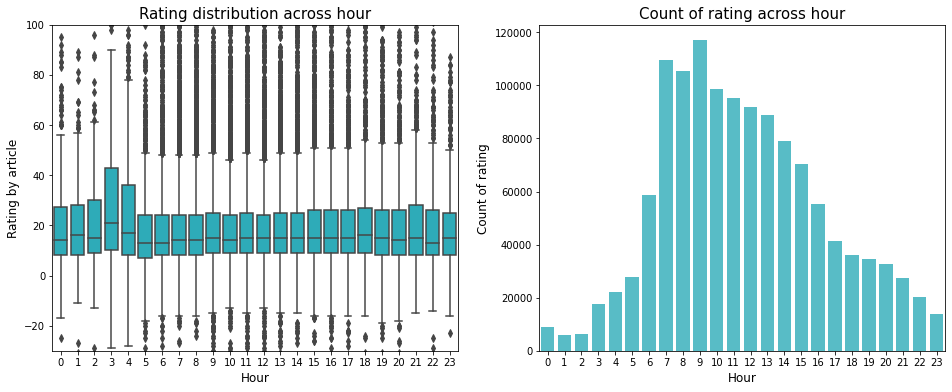

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(121)
ax1 = sns.boxplot(y='rate',x='hour', data=subsample, color=color[9])
plt.ylim(-30,100)
plt.ylabel('Rating by article', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.title('Rating distribution across hour', fontsize=15)

plt.subplot(122)
temp = subsample.groupby('hour')['rate'].sum()
ax2 = sns.barplot(temp.index,temp.values, alpha=0.8, color=color[9])
plt.ylabel('Count of rating', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.title('Count of rating across hour', fontsize=15);

Наибольший суммарный рейтинг набирают статьи, опубликованные в утренние часы, минимум приходится на статьи, опубликованные ночью.

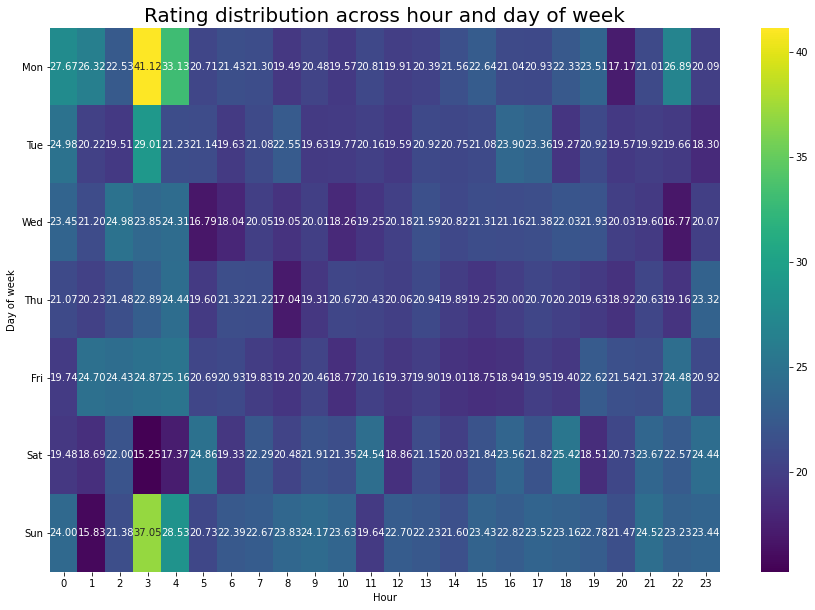

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Rating distribution across hour and day of week', fontsize=20)
temp = subsample.pivot_table(index='weekday', columns='hour', values='rate', aggfunc='mean')
ax = sns.heatmap(temp, annot=True, fmt='.2f', cmap='viridis')
ax.set(xlabel='Hour', ylabel='Day of week')
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks(rotation='horizontal');

## 2.3. Other features

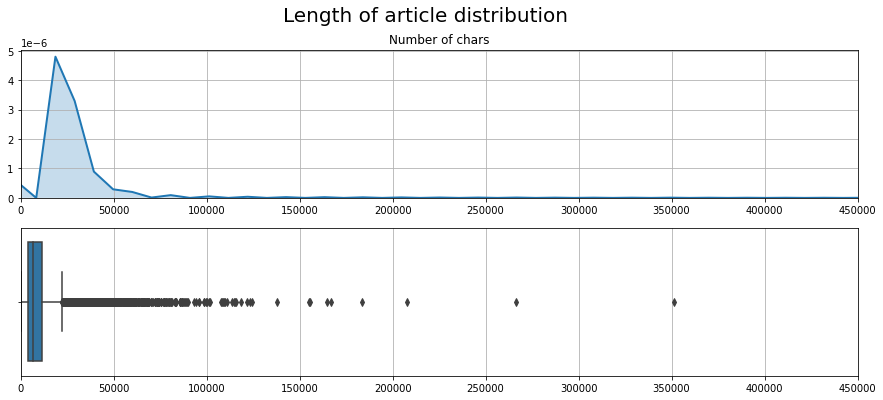

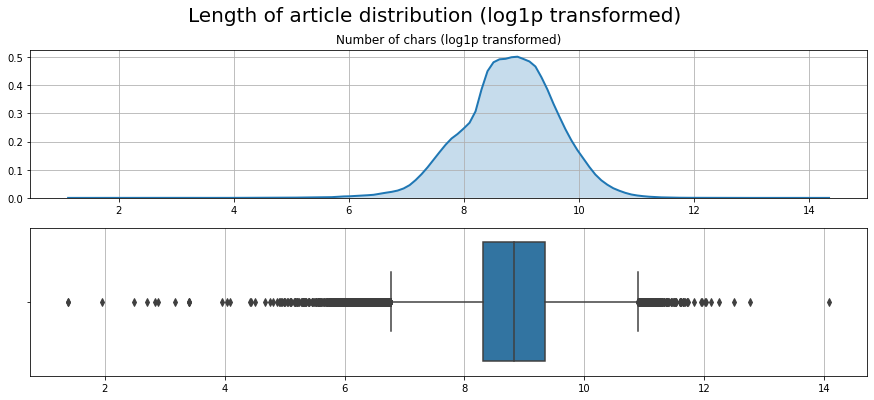

In [ ]:
plt.figure(figsize=(15,6))
plt.suptitle("Length of article distribution",fontsize=20)
gridspec.GridSpec(2,1)

plt.subplot2grid((2,1),(0,0))
plt.xlim(0, 450000)
plt.grid(True)
sns.distplot(subsample.text_lenght.values, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.title("Number of chars")

plt.subplot2grid((2,1),(1,0))
plt.xlim(0, 450000)
plt.grid(True)
sns.boxplot(subsample.text_lenght.values);

plt.figure(figsize=(15,6))
plt.suptitle("Length of article distribution (log1p transformed)",fontsize=20)
gridspec.GridSpec(2,1)

plt.subplot2grid((2,1),(0,0))
sns.distplot(np.log1p(subsample.text_lenght.values), hist=False, color=color[0], kde_kws={"shade": True, "lw": 2})
plt.grid(True)
plt.title("Number of chars (log1p transformed)")

plt.subplot2grid((2,1),(1,0))
plt.grid(True)
sns.boxplot(np.log1p(subsample.text_lenght.values));

# 3. Baselines

In [ ]:
%%time
subsample['clean_text'] = subsample['text'].apply(pr.clean_text)

CPU times: user 1min 12s, sys: 7.4 s, total: 1min 20s
Wall time: 1min 20s


In [ ]:
%%time
subsample['lemmas'] = subsample['clean_text'].apply(pr.lemmatization)

CPU times: user 27min 14s, sys: 2.29 s, total: 27min 16s
Wall time: 27min 16s


In [ ]:
#subsample = pd.read_pickle("./subsample.pkl")

In [ ]:
subsample['lemmas'] = subsample['lemmas'].apply(str)

In [ ]:
y = subsample['rate'].values
text = subsample['text'].values.tolist()
title = subsample['title'].values.tolist()
clean_text = subsample['clean_text'].values.tolist()
lemmas = subsample['lemmas'].values
# удаление столбца с датой
subsample.reset_index(drop=True, inplace=True)
subsample.drop(['title', 'text', 'text_lenght', 'rate', 'clean_text', 'lemmas'], axis=1, inplace=True)

## 3.1. Simple baseline: raw text data + dummies


In [ ]:
subsample.columns

Index(['weekday', 'year', 'month', 'hour'], dtype='object')

In [ ]:
%%time

list_to_dums = ['weekday', 'year', 'month', 'hour']
dummies = pd.get_dummies(subsample, columns = list_to_dums, drop_first=True,
                            prefix=list_to_dums, sparse=False)

CPU times: user 29.2 ms, sys: 458 µs, total: 29.6 ms
Wall time: 31.1 ms


In [ ]:
X_train_feats, X_test_feats, y_train, y_test = train_test_split(
    dummies, y, test_size=0.3, random_state=42, shuffle = False)

text_train, text_test = train_test_split(
    text, test_size=0.3, random_state=42, shuffle = False)

title_train, title_test = train_test_split(
    title, test_size=0.3, random_state=42, shuffle = False)

print('TRAIN feats: {}'.format(X_train_feats.shape))
print('TEST feats: {}'.format(X_test_feats.shape))

TRAIN feats: (42739, 43)
TEST feats: (18318, 43)


### 3.1.1. Count Vectorizer


In [ ]:
%%time
cv_text = CountVectorizer(max_features=50000)

X_train_text = cv_text.fit_transform(text_train)
X_test_text = cv_text.transform(text_test)

print('TRAIN text: {}'.format(X_train_text.shape))
print('TEST text: {}'.format(X_test_text.shape))
del text_train, text_test
gc.collect()

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 1min 13s, sys: 2.28 s, total: 1min 15s
Wall time: 1min 15s


#### 3.1.1.1. Ridge Regression


Обучение исключительно на текстах


In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_text, y_train)
y_pred = ridge.predict(X_test_text)

CPU times: user 14min 12s, sys: 10min 3s, total: 24min 16s
Wall time: 12min 20s


In [ ]:
print("MAE for raw texts and ridge regression:", mean_absolute_error(y_test, y_pred))

MAE for raw texts and ridge regression: 43.29201394357311


Обучение на текстах и категориальных переменных

In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_text, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_text, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred = ridge.predict(X_test_sparse)

CPU times: user 15min 1s, sys: 10min 22s, total: 25min 24s
Wall time: 12min 51s


In [ ]:
mean_absolute_error(y_test, y_pred)

42.895550866691565

##### 3.1.1.1.1  Feature importance

In [ ]:
top30_plus = np.argsort(ridge.coef_)[-30:][::-1]
top30_plus

array([48176, 23448, 14283, 32483, 31366, 31703, 35825, 17459, 19641,
       24408, 31030, 33585, 17245, 11924, 32077,  1101, 46889, 16738,
       16106, 31694, 20902, 16280,  7803, 26412, 21718, 49842, 47844,
       26176, 28935, 14096])

In [ ]:
top30_minus = np.argsort(ridge.coef_)[:30]
top30_minus


array([23545, 29447, 38076, 22676, 27312,  5839, 44475, 30401, 30411,
       46397, 20090, 46478, 41831, 17253,  5990,  4336, 29720, 33199,
        6584,  7042, 13876, 25023, 42342, 48539, 33299, 40785,  9794,
       34933, 44751, 49979])

In [ ]:
feats_plus=[]
feats_minus=[]
for idx in top30_plus:
    if idx<X_train_text.shape[1]:
        feats_plus.append(list(cv_text.vocabulary_.keys())[list(cv_text.vocabulary_.values()).index(idx)])
for idx in top30_minus:
    if idx<X_train_text.shape[1]:
        feats_minus.append(list(cv_text.vocabulary_.keys())[list(cv_text.vocabulary_.values()).index(idx)])

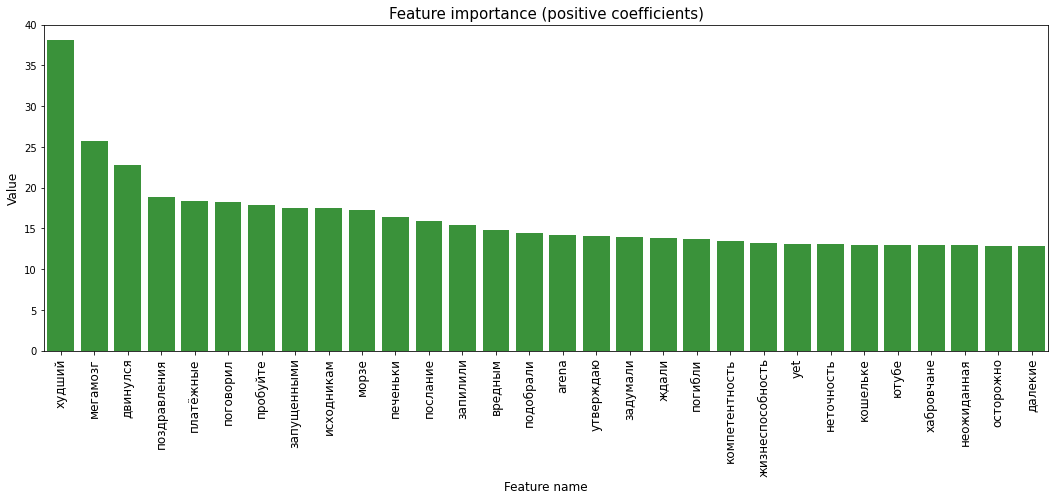

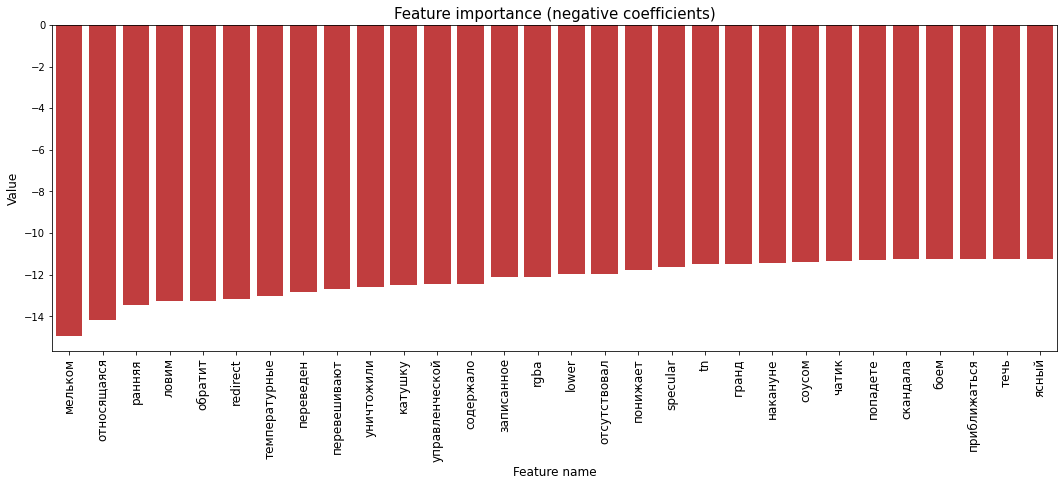

In [ ]:
plt.figure(figsize=(18,6))
ax1 = sns.barplot(feats_plus,ridge.coef_[top30_plus],color=color[2])
plt.ylabel('Value', fontsize=12)
plt.xlabel('Feature name', fontsize=12)
plt.title('Feature importance (positive coefficients)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12)
    
plt.figure(figsize=(18,6))
ax2 = sns.barplot(feats_minus,ridge.coef_[top30_minus],color=color[3])
plt.ylabel('Value', fontsize=12)
plt.xlabel('Feature name', fontsize=12)
plt.title('Feature importance (negative coefficients)', fontsize=15)
plt.grid(False)
plt.xticks(rotation=90, fontsize=12);

#### 3.1.1.2. Linear Regression

Обучение на текстах и категориальных переменных

In [ ]:
%%time

LR = LinearRegression()
LR.fit(X_train_text, y_train)
y_pred = LR.predict(X_test_text)

CPU times: user 1h 34min 9s, sys: 1h 6min 52s, total: 2h 41min 2s
Wall time: 1h 21min 25s


In [ ]:
print("MAE for raw texts and linear regression:", mean_absolute_error(y_test, y_pred))

MAE for raw texts and linear regression: 264.10340346505126




## 3.2. Baseline: cleared text + dummies


In [ ]:
subsample.columns

Index(['weekday', 'year', 'month', 'hour'], dtype='object')

In [ ]:
%%time

list_to_dums = ['weekday', 'year', 'month', 'hour']
dummies = pd.get_dummies(subsample, columns = list_to_dums, drop_first=True,
                            prefix=list_to_dums, sparse=False)

CPU times: user 19.5 ms, sys: 1.03 ms, total: 20.5 ms
Wall time: 22.5 ms


In [ ]:
X_train_feats, X_test_feats, y_train, y_test = train_test_split(
    dummies, y, test_size=0.3, random_state=42, shuffle = False)

clean_text_train, clean_text_test = train_test_split(
    clean_text, test_size=0.3, random_state=42, shuffle = False)

print('TRAIN feats: {}'.format(X_train_feats.shape))
print('TEST feats: {}'.format(X_test_feats.shape))

TRAIN feats: (42739, 43)
TEST feats: (18318, 43)


### 3.2.1. Count Vectorizer

In [ ]:
%%time
cv_clean_text = CountVectorizer(max_features=50000)

X_train_clean_text = cv_clean_text.fit_transform(clean_text_train)
X_test_clean_text = cv_clean_text.transform(clean_text_test)

print('TRAIN text: {}'.format(X_train_clean_text.shape))
print('TEST text: {}'.format(X_test_clean_text.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 1min 9s, sys: 989 ms, total: 1min 10s
Wall time: 1min 10s


#### 3.2.1.1. Ridge Regression

Обучение исключительно на текстах

In [ ]:
#train test split: shuffle = False
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_clean_text, y_train)
y_pred = ridge.predict(X_test_clean_text)

CPU times: user 13min 44s, sys: 9min 37s, total: 23min 21s
Wall time: 11min 52s


In [ ]:
print("MAE for clean texts and ridge regression, shuffle=False:", mean_absolute_error(y_test, y_pred))

MAE for clean texts and ridge regression, shuffle=False: 41.8437363300904


In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_clean_text, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_clean_text, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 1.4 s, sys: 12.4 ms, total: 1.41 s
Wall time: 1.41 s


Обучение на текстах и категориальных переменных


In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred = ridge.predict(X_test_sparse)

CPU times: user 13min 36s, sys: 9min 28s, total: 23min 5s
Wall time: 11min 55s


In [ ]:
print("MAE for clean texts, dummies and ridge regression, shuffle=False:", mean_absolute_error(y_test, y_pred))

MAE for clean texts, dummies and ridge regression, shuffle=False: 41.51842543685178


### 3.2.2. TF-IDF Vectorizer

In [ ]:
%%time
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

X_train_clean_text_tfidf = tfidf.fit_transform(clean_text_train)
X_test_clean_text_tfidf = tfidf.transform(clean_text_test)

print('TRAIN text: {}'.format(X_train_clean_text_tfidf.shape))
print('TEST text: {}'.format(X_test_clean_text_tfidf.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 6min 31s, sys: 6.44 s, total: 6min 37s
Wall time: 6min 38s


In [ ]:
#X_train_clean_text_tfidf = sparse.load_npz("X_train_clean_text_tfidf.npz")
#X_test_clean_text_tfidf = sparse.load_npz("X_test_clean_text_tfidf.npz")

In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_clean_text_tfidf, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_clean_text_tfidf, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 3.42 s, sys: 310 ms, total: 3.73 s
Wall time: 3.75 s


#### 3.2.2.1. Ridge Regression

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred = ridge.predict(X_test_sparse)

CPU times: user 28.7 s, sys: 17.8 s, total: 46.5 s
Wall time: 25.3 s


In [ ]:
print("MAE for clean texts, dummies and ridge regression, shuffle=False:", mean_absolute_error(y_test, y_pred))

MAE for clean texts, dummies and ridge regression, shuffle=False: 16.392798649660655


#### 3.2.2.2. LightGBM

In [ ]:
param = {'num_trees': 100000, 'application':'regression',
         'learning_rate': 0.01, 'num_threads': 7, 'max_depth': 10,
         'lambda_l2': 1e-3}
param['metric'] = 'mae'

In [ ]:
train_data = lgb.Dataset(X_train_sparse, label=y_train)
test_data = train_data.create_valid(X_test_sparse, label=y_test)

In [ ]:
%%time 
bst = lgb.train(param, train_data, param['num_trees'], valid_sets=[test_data], early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_trees` in params. Will use it instead of argument



[1]	valid_0's l1: 15.7048
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l1: 15.6891
[3]	valid_0's l1: 15.6733
[2160]	valid_0's l1: 14.1602
[2161]	valid_0's l1: 14.1603
[2162]	valid_0's l1: 14.1603
[2163]	valid_0's l1: 14.1606
[2164]	valid_0's l1: 14.1608
[2165]	valid_0's l1: 14.1608
[2166]	valid_0's l1: 14.1606
[2167]	valid_0's l1: 14.1605
[2168]	valid_0's l1: 14.161
[2169]	valid_0's l1: 14.1608
[2170]	valid_0's l1: 14.1606
[2171]	valid_0's l1: 14.1605
[2172]	valid_0's l1: 14.1606
[2173]	valid_0's l1: 14.1607
[2174]	valid_0's l1: 14.1606
[2175]	valid_0's l1: 14.1605
[2176]	valid_0's l1: 14.1605
[2177]	valid_0's l1: 14.1606
[2178]	valid_0's l1: 14.161
[2179]	valid_0's l1: 14.161
[2180]	valid_0's l1: 14.1609
[2181]	valid_0's l1: 14.1609
[2182]	valid_0's l1: 14.1609
[2183]	valid_0's l1: 14.161
[2184]	valid_0's l1: 14.1611
[2185]	valid_0's l1: 14.1611
[2186]	valid_0's l1: 14.1613
[2187]	valid_0's l1: 14.1611
[2188]	valid_0's l1: 14.1611
[2189]	valid_0's l1: 14

## 3.3. Baseline: lemmas + dummies

In [ ]:
subsample.columns

Index(['weekday', 'year', 'month', 'hour'], dtype='object')

In [ ]:
%%time

list_to_dums = ['weekday', 'year', 'month', 'hour']
dummies = pd.get_dummies(subsample, columns = list_to_dums, drop_first=True,
                            prefix=list_to_dums, sparse=False)

CPU times: user 22.7 ms, sys: 888 µs, total: 23.5 ms
Wall time: 30.3 ms


In [ ]:
X_train_feats, X_test_feats, y_train, y_test = train_test_split(
    dummies, y, test_size=0.3, random_state=42, shuffle = False)

In [ ]:
X_train_lemmas, X_test_lemmas, y_train, y_test = train_test_split(
  lemmas, y, test_size=0.3, random_state=42, shuffle = False)

print('TRAIN: {}'.format(X_train_lemmas.shape))
print('TEST: {}'.format(X_test_lemmas.shape))

TRAIN: (42739,)
TEST: (18318,)


### 3.3.1. Count Vectorizer

In [ ]:
%%time
cv_lemmas = CountVectorizer(max_features=50000)

X_train_lemmas_cv = cv_lemmas.fit_transform()
X_test_lemmas_cv = cv_clean_text.transform(clean_text_test)

print('TRAIN text: {}'.format(X_train_lemmas_cv.shape))
print('TEST text: {}'.format(X_test_lemmas_cv.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 1min 6s, sys: 560 ms, total: 1min 6s
Wall time: 1min 6s


#### 3.3.1.1. Ridge Regression

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_lemmas_cv, y_train)
y_pred_lemmas = ridge.predict(X_test_lemmas_cv)

CPU times: user 13min 24s, sys: 9min 25s, total: 22min 49s
Wall time: 11min 35s


In [ ]:
print("MAE for lemmas and ridge regression:", mean_absolute_error(y_test, y_pred_lemmas))

MAE for lemmas and ridge regression: 41.8437363300904


In [ ]:
%%time

X_train_lemmas_sparse = csr_matrix(hstack([X_train_lemmas_cv, X_train_feats.values])) 
X_test_lemmas_sparse = csr_matrix(hstack([X_test_lemmas_cv, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 1.16 s, sys: 1.33 s, total: 2.48 s
Wall time: 2.52 s


In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_lemmas_sparse, y_train)
y_pred_lemmas = ridge.predict(X_test_lemmas_sparse)

CPU times: user 13min 33s, sys: 9min 29s, total: 23min 2s
Wall time: 11min 49s


In [ ]:
print("MAE for lemmas, dummies and ridge regression:", mean_absolute_error(y_test, y_pred_lemmas))

MAE for lemmas, dummies and ridge regression: 41.51842543685178


### 3.3.2. TF-IDF Vectorizer

In [ ]:
%%time
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

X_train_lemmas_tfidf = tfidf.fit_transform(X_train_lemmas)
X_test_lemmas_tfidf = tfidf.transform(X_test_lemmas)

print('TRAIN lemmas: {}'.format(X_train_lemmas_tfidf.shape))
print('TEST lemmas: {}'.format(X_test_lemmas_tfidf.shape))

TRAIN text: (42739, 50000)
TEST text: (18318, 50000)
CPU times: user 3min 30s, sys: 4.09 s, total: 3min 34s
Wall time: 3min 34s


In [ ]:
#X_train_lemmas_tfidf = sparse.load_npz("X_train_lemmas_tfidf.npz")
#X_test_lemmas_tfidf = sparse.load_npz("X_test_lemmas_tfidf.npz")

In [ ]:
%%time

X_train_sparse = csr_matrix(hstack([X_train_lemmas_tfidf, X_train_feats.values])) 
X_test_sparse = csr_matrix(hstack([X_test_lemmas_tfidf, X_test_feats.values]))
print(X_train_sparse.shape, X_test_sparse.shape)

(42739, 50043) (18318, 50043)
CPU times: user 2.34 s, sys: 69.8 ms, total: 2.41 s
Wall time: 2.41 s


#### 3.3.2.1. Ridge Regression

In [ ]:
%%time

ridge = Ridge(random_state=17)                          
ridge.fit(X_train_sparse, y_train)
y_pred_lemmas = ridge.predict(X_test_sparse)

CPU times: user 33.5 s, sys: 19.4 s, total: 52.9 s
Wall time: 30.3 s


In [ ]:
print("MAE for lemmas, dummies and ridge regression:", mean_absolute_error(y_test, y_pred_lemmas))

MAE for lemmas, dummies and ridge regression: 16.982229088808964


#### 3.3.2.2. LightGBM

In [ ]:
param = {'num_trees': 100000, 'application':'regression',
         'learning_rate': 0.01, 'num_threads': 7, 'max_depth': 10,
         'lambda_l2': 1e-3}
param['metric'] = 'mae'

In [ ]:
train_data = lgb.Dataset(X_train_sparse, label=y_train)
test_data = train_data.create_valid(X_test_sparse, label=y_test)

In [ ]:
%%time 
bst = lgb.train(param, train_data, param['num_trees'], valid_sets=[test_data], early_stopping_rounds=50)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_trees` in params. Will use it instead of argument



[1]	valid_0's l1: 15.7069
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l1: 15.6934
[3]	valid_0's l1: 15.6801
[2677]	valid_0's l1: 14.099
[2678]	valid_0's l1: 14.0991
[2679]	valid_0's l1: 14.0991
[2680]	valid_0's l1: 14.0991
[2681]	valid_0's l1: 14.0992
[2682]	valid_0's l1: 14.0992
[2683]	valid_0's l1: 14.0996
[2684]	valid_0's l1: 14.0996
[2685]	valid_0's l1: 14.0995
[2686]	valid_0's l1: 14.0996
[2687]	valid_0's l1: 14.0994
[2688]	valid_0's l1: 14.0995
[2689]	valid_0's l1: 14.0995
[2690]	valid_0's l1: 14.0995
[2691]	valid_0's l1: 14.0994
[2692]	valid_0's l1: 14.0994
[2693]	valid_0's l1: 14.0991
[2694]	valid_0's l1: 14.0992
[2695]	valid_0's l1: 14.0992
[2696]	valid_0's l1: 14.0993
[2697]	valid_0's l1: 14.0992
[2698]	valid_0's l1: 14.0993
[2699]	valid_0's l1: 14.0992
[2700]	valid_0's l1: 14.0993
[2701]	valid_0's l1: 14.0994
[2702]	valid_0's l1: 14.0994
[2703]	valid_0's l1: 14.0994
[2704]	valid_0's l1: 14.0995
[2705]	valid_0's l1: 14.0996
[2706]	valid_0's l1:

# 4. Anomaly detection

## 4.1. Prophet

In [9]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

### 4.1.1. Prepearing data

Суммарный рейтинг за каждый месяц

In [15]:
rating_monthly_df = pd.DataFrame(subsample.rate.resample('M').sum())

In [16]:
rating_monthly_df.head()

,rate
date,
2016-01-31,22345
2016-02-29,23477
2016-03-31,26360
2016-04-30,23774
2016-05-31,22018


In [17]:
rating_monthly_df['ds'] = rating_monthly_df.index
rating_monthly_df.reset_index(drop=True, inplace=True)

In [18]:
rating_monthly_df.columns = ['y', 'ds']

Суммарный рейтинг за каждую неделю

In [19]:
rating_weekly_df = pd.DataFrame(subsample.rate.resample('W').sum())

In [20]:
rating_weekly_df.head()

,rate
date,
2016-01-03,975
2016-01-10,3627
2016-01-17,5990
2016-01-24,5420
2016-01-31,6333


In [21]:
rating_weekly_df['ds'] = rating_weekly_df.index
rating_weekly_df.reset_index(drop=True, inplace=True)

In [22]:
rating_weekly_df.columns = ['y', 'ds']

Суммарный рейтинг за каждый день

In [23]:
rating_daily_df = pd.DataFrame()
rating_daily_df['rate'] = subsample.rate.resample('D').sum()
rating_daily_df.head()

,rate
date,
2016-01-01,231
2016-01-02,285
2016-01-03,459
2016-01-04,542
2016-01-05,608


In [24]:
rating_daily_df['ds'] = rating_daily_df.index
rating_daily_df.reset_index(drop=True, inplace=True)

In [25]:
rating_daily_df.head()

,rate,ds
0,231,2016-01-01
1,285,2016-01-02
2,459,2016-01-03
3,542,2016-01-04
4,608,2016-01-05


In [26]:
rating_daily_df.columns = ['y', 'ds']

### 4.1.2. Forecasting

Используем в модели следующие параметры:
* growth - тип тренда
* yearly_seasonality - годовая сезонность
* weekly_seasonality - недельная сезонность
* праздничные дни
* changepoint_range - доля исторических данных (начиная с самого первого наблюдения), в пределах которых будут оценены точки излома тренда
* seasonality_mode - режим моделирования сезонных компонентов
* interval_width - число, определяющее ширину доверительного интервала для предсказанных моделью значений


#### 4.1.2.1. Overall rating weekly


Displaying Prophet plot
CPU times: user 2.88 s, sys: 165 ms, total: 3.04 s
Wall time: 3.81 s


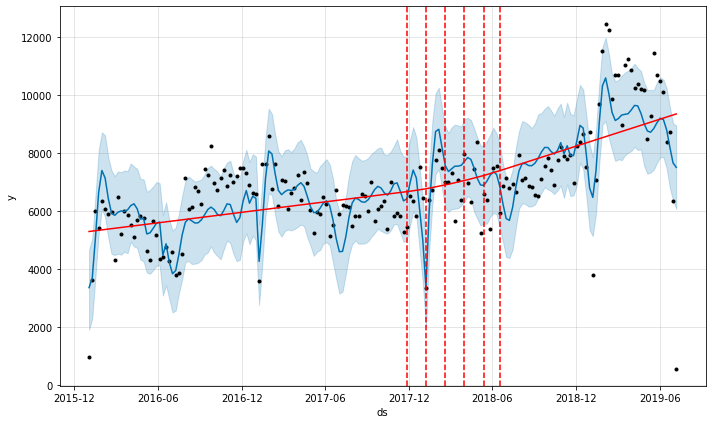

In [27]:
%%time


def fit_predict_model(dataframe, interval_width = 0.8, changepoint_range = 0.8):
    
    m = Prophet(daily_seasonality = False, growth = 'linear', yearly_seasonality = 'auto', weekly_seasonality = False,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m.add_country_holidays(country_name='RU')
    m = m.fit(dataframe) 
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    a = add_changepoints_to_plot(fig1.gca(), m, forecast)
    return forecast
    
pred = fit_predict_model(rating_weekly_df)

* Черные точки соответствуют значениям отклика из обучающей выборки 
* Сплошная голубая линия - это предсказанные моделью значения отклика
* Огибающая эту линию светло-голубая "лента" - это 80% доверительные интервалы соответствующих предсказанных значений 
* Сплошная красная линия - тренд, оцененный с помощью модели
* Штриховые красные линии - оцененные точки излома тренда

Увеличим  интервал до 90%, воспользовавшись аргументом changepoint_range. Также явно зададим количество потенциальных точек излома.

Displaying Prophet plot
CPU times: user 1.82 s, sys: 108 ms, total: 1.92 s
Wall time: 1.91 s


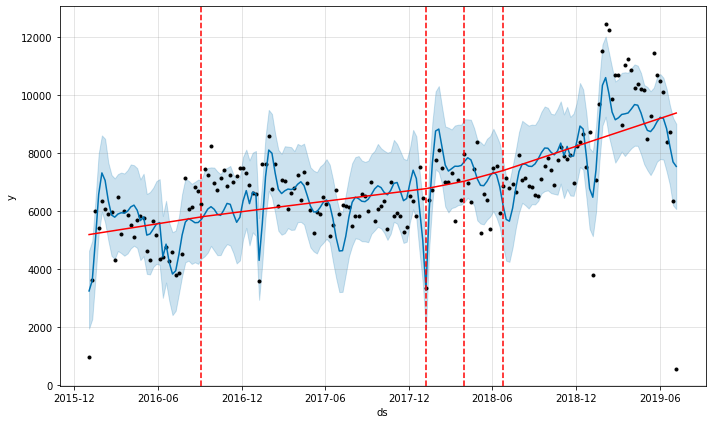

In [28]:
%%time


def fit_predict_model(dataframe, interval_width = 0.8, changepoint_range = 0.9):
    
    m = Prophet(daily_seasonality = False, growth = 'linear', yearly_seasonality = 'auto', weekly_seasonality = False,
                n_changepoints=14,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m.add_country_holidays(country_name='RU')
    m = m.fit(dataframe) 
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    a = add_changepoints_to_plot(fig1.gca(), m, forecast)
    return forecast
    
pred = fit_predict_model(rating_weekly_df)

Видно, что с изменением конфигурации модель стала лучше определять точки излома тренда.

### 4.1.3. Plotting

Будем считать аномалией любую точку, которая  находится за границами (то есть выше или ниже) 80%-го доверительного интервала. Важность аномалии определяется расстоянием от нее до границ доверительного интервала. Аномалии изображаются красными точками.

In [29]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [30]:
import altair as alt

In [ ]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
   ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Overall weekly rating'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Overall weekly rating'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=1000, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

В результате выполнения ячейки выше никакого графика не выводится, так как GitHub не умеет отображать интерактивные графики. Поэтому прикрепляю статичный.

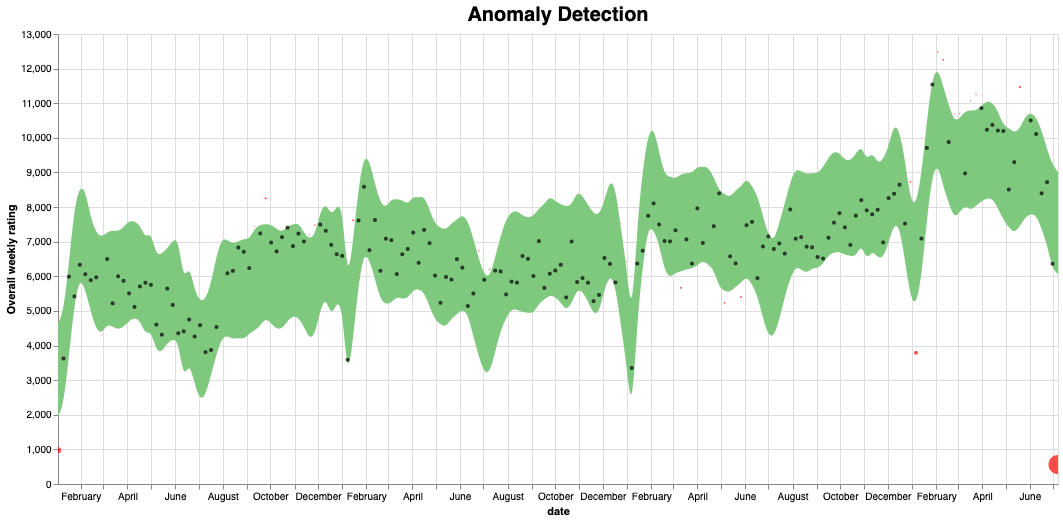

[Ссылка на интерактивный график](https://vega.github.io/editor/#/url/vega-lite/N4KABGBEDGD2B2AzAlgc0gLjKCFIDdkBTAd02xgQBdl4BXWOgZwHVkATKgC3IBYAGfgBooceDXqMmACSJouVcgGZBAXyHhckGlQA2RcsEiJqAZWQAvA1gBM-VZvWbIugIYBPIgCdyAbU0QOLh47K5UroaQ8K4AttZQoeEAtACciK4AjACs0LwZ0CkARjYpSpkpROwA7IWCNsWIiEpE-LyQTsF4Ma5eANaRVO4ADvGQPUQRIpS6sD5YkADEVQBiAMIpK5BTtFTeQ7Buu+SQha5MyEztGp1QRPBw7LToWEE32rAHNEN+ATcUgyNjrsYvsvK5dFsoCgiLp2Md2JcOn9AtphqMAI50VziZDhGj4AxTaGw47paCKJHIowAjFYnF45AEyHGYgk+buLhhAD6MxI3iuvxu1LRx0x2J0YUZhKhrLh7M5VC5dCGIx8DmRAF1rn9IAAPAYi+bA0Hg5nEuUJS5THT6eFhAyUzqQdwGwHzMX0yVMomy44c7nK1UC5HOmyRc1+hU82B8tWCsCOvBMGFEcnIBCGeNJlPk2aCDKZ5F4GnHHbefCm7Uhwq0C2QJjQcFEK1ZrR3B5PS5YXx65kujWt9WdRNQG2jACC8Fg3V07jAABEiLs0xnfo7XlpEhEXlFYqMt0kAGxVVyIFr8KpVdhEHK1IgZdjsJRZJSFaDsQ8pLI5fiH4NO7o+ldUZoGQLxoFtKY4BmOYoAAITcaB+imWAhlcUDBnIfgADoqimc4rHIbIR0gdtYEeeBnmwVt3k+ZBvm7VsURLI0iBBWZKxlGE6wRf8qVRN0oA9CV8WlFluNJdCKSrP5hUEyBhNxL0xIjeVuV5fkR2COTaXFJTRLNX01MVQNNNbLUaP1HcWNHNiTQhH0JPmXitKgF0XiY0dDSEukRKlLZPPEtkoSkgKi1HXFbXmAB5AkwV0XQwD5IhelnMAwQkdBB3jEjk30Fd4ELHU8tTKg834MMPPCgTRjLLwKwcwKa3gOsGybFtqrIijUC7MAe31KZ+2ym4hwgdd40gLdImiOI7WSGwlEQDIUhsXJXCyAAOQ9oBvRBNuaVwqg21oagyQ8bzDEjAP6azvJgMCILE6DZmOAAlSpmQI+IVBIrqniKt4vuA0VfP0-zHOCyBkHYrxwnuMT9FQO4LXoBLXNo3Qvh+cKdKBOyOIcrjIZcmShRqkG9IZb0ibrMlpM83H3VBqmVKMtyow0tVSc6RmfMp5TDKc9mAxVMzNW5vArP+O7jQJwXicRCW3IBnUbIU5mBaVvBVJC8kwqLbRItGWLvHBRLktSucMv+4bh25+scxoDMquKx3yqUFW3jVuqGv16ta2ONr9A6g2-so3r+r7SAB2RUbcDjocLLwLg5FQBQ+CyYRnBIDhuCIwQs7wAASBsU+6Y4FCoIYmAwAB6WuCVQVxsNQXEuDoQpsPTWvS7Y1wG6IJukl0XEiAb3hsI27CMmwgArJgM21SawjOJdeo3ZfkjSTIcjyApilKcpKhqOoGiaFo2kYoUaN4+Y7DOpJ+AyR+lAAFUEDAP8EP2nSoLxkfIFkDIG0UjYRsBkXgL5DyHggQtJWzoFTKBsHkbCSgtqlBSLwUovAjrwP9IqTmRFMEz0wVUDIwCzq8CUEoKoh48FRlMrBXgh4lAz0POA1oVCsiHk2lkeBdNyAbD4TRbE05wTuTAEkDI8DoagjhjtLC2EUgpAyFUAQLCBAQKqPwIBOVuYbmCJNXqkB76Hkfs-DI-B378E-jY7+8C-4AKwFkOwh5cIwJSBVEBAhfz0LCMoQ8OiwEbRwTQyhVQbDHj8QQmM-JbA2DIdhFh0CKo8I2mdLIvBolKlFkwjYNhsL8A2jYIBZDnwlGkTRARWAlDsLwiIqcM4JGFx1LI2Y8j4j8D0fGAxm5jGmPMVIqo1jbG2J-oYxxLVAE2GQag-gK1PyqJoek6JgCKqgOWrwBaK1MFFO-NkwhNTtE4SofM1o2DAkhOyYw8gLDjpKIWmorI2i6kbX4aFZxyiWlvFEU0rCMiYYdKwt06+IZb5QAGU-JIyCRlf34OMrQkyLQuJQRtbhLDMkvm-PUkM+DbnPI2YEjItSlCuJSG8mi+DoyxmmeQ7CkDtERPSaUI6wjcUMNyeQKo5Kqi4TRcgkJ6CcHvL1s4rZ3ynS-PEf8mibTYbYgUVgLpI19E336U-MxULWGwrsfChx-8pnOJKaAgQPilnUOoasrAVRWFTx4cglxZ1nzkIObE2CWQNhuN-DMr8F5M7MOuZyrAW0MgFI2to5aX5SXLRFYoLALDLUNLEbOGVIY5VAqVSCnmarjiQpsI-YZcKxn6qcWAFxtClFANqcdYlliKXsv8danRoDinFKOoeKhvANr1p1FSw5ZaYE4Rcawy8L5wFqMDUGYNWCshJK2nYNFLCFmxtub+SpIYpUpqVQCuRCrOlZu0jmu+GrH75ogTq4tNEkXTMwfSnlSgtkrW7c+K1YAMVuI7UoTBHaEmQJSK6mlWAsForAQtY6yDuW-joZSjlU6wC0JtZPGd2DnlnRXc47tPafmNOldu2VgK93ApVT0o9EKT0VWhRkC99ir0GuRawgprRB06IiTw-9MHG1lq2rOqomTPF+sib4jjMTANgF4JAieNqn4bBoc+TJk64nweQaAj15LQ1PM2uhstGwJWGM3c0nd7TCOZuI6CnU4KTHkfzTYDa1G9W0dLWOlTFzDz8q4a+55ID6XHW5c8r9Oi0UAcU52yTrCcElM-TwhTsEyE2dwstfMZ15lfi01Q4l8D9PkCkYZ+V8NFGCBtahz8MCQk4PYTYA9uBekhHVQ-fgShH6Hjswi4sdHAEPt5RAop1DiUzJdcJwBIDeUopwa0bID7129o5m6vg7ClBgMvCtBJyjjyTbeFSm51qEm8rsLajYNaNhaY7eSjLOGt1gF01odNxmLuVcCKRyzdWGvEuayWw1ZbakT1c8y4hy0toecwQUtBWy-PgI0UFphmSp4hM8QuhdwDotcuoThY8S7yWRMsTYLTjr2MbrOwZ-Du68smbtiRsFtXNUNbsK9hz72XzFLAXJnhizaFY4G58ko2EgE2bQQu7hbOG0ieC5AqeeRjw2ZAQ+koiOtsbCQyobI35ancKO-mU7yaCdpoI8T27pns3k9zeRqnhbdWXpDNe5xX7QFHRKKwjY42cVTc46p2dmcNElGPCoAXTuheQ5oVzsJ9XKFPzZT7nJcG1EQNQcUwJzyZloOgyGapXHtHq7+XhrXRPFW69J2Zt4FnIW8BfjT83bWxWqNQV78l9XjpYNfTA8TSieFhKlzAxPYf+04NDYUn1ETSmYKUDL+DMCZ6UIgV2xdUSqkfLLZnR32GNeptadr7Pyrc-6-MxTx+RfLEl9VmXstnbJ6XmgXkVoKv2dvrsLOtBaKjqWNJWgiHfBjrzd48s5TF4VpD94yE+LZ0Fov9lE1snRk8gE0Mk108LscsM0c9ggRxqtLRDc6sd8TdRkaNS9HNIECkQd6sn4yELwQDDE8V411kkk7AVFuEKoPV291tptRNws7ViUsFshLFPEsMnQNsg14Mu0cDBNwE-1xdsdGU09cNoDCcjMdc194DVUDdj0UDoVeA98vYD9MlPwlEIkv05tf9vc6DndjwcJyUoESVMk69hNqVgsVATVxMUgDDFdVEf95kCkVFLEO0llw1Q83gwD0lPDJV8cl83hrspC7tqI5CyM6sshzFlDf5VCu1htlpWcVABBSgPNjoUcQ8bM+9u1shn8gNxNnDnwuEZkCVB9zDNslMvM1EKpiVWMNoH1hD5NICxDLs8AgjV8QjECjFkDNVIiiloiJlVDM5Z1fxYs6iXkdEPMzoW0gEtlIlXFcFzD+00FSV6V8DYE8h0l6iyjuC0leUIkKpWFWh5lnlfDDFk9mEhM8dF8M9l8s9909dD0wjHseipEsh+jEVBiZkklx9MEqEyEcjL9HUZ51kElyFfxSjBcLDYI0Fu9AlPEdk8gA1ti4NoFnlp48heNQ0jjNNp9RUxMwtRDzsWioA2j7j19HjN9ujH5IiZl3jWtHNMkcIzpgFY96s6kPMaE3EBDvtHValaDOD6DgsLwcDVE1EbUeEXEODiDYNFNXNfwkMIEPUcEjoaFscO1TitBMsbjAiV8ySZCydKT5CXiSg6TRxBi0TtElseEI00ENS8ASDZ8Xx6VWFbVilM5WhcixNVEp5MlqFPFmEIt58BSRYI96tJNwF9p75nx+SziZ9SkiDNT-DtSnRSSiNySqsHtIUejTTtBBjeMwFuEPVIk+S7ThY40B16tJ4Lxm0vllFccO8ZsgMIF5s-s3DtEPVw0f9LEJ5bDIlsEVEShdDQCZ8uFSyxgkzxDM9JD2iHiMynisypEbAcyLdZ8Voqyv1NptFWEYFX1xMK9eNXMusNgVEslFjGywAVAgk-sbNxMqFDyYytAuC4N9p5tCjSVvx1lWFUs8gEy8AtTJzbjpy9T45ZDDTwjNUzFlplzVDB1UEq0FpoEVFKDdy0Up4ElIlPxw1vSgzpT1JzznwVBcIodDyShCycLHyZTYIMVeUC4YFqEXFktUteMhy9MJziSoZdS0z9S88nQC9yMzFIloLHM6lJ5yVvsMUZkWKKLONZicIE9M4aFqiZlPSbNShRLPwwMQFRTyL7TKLAFNprdlEH0ilyFIExzziMdCTNdALcsZz0z7t5zyMqhi8i0MD99hLIF6ULioEn4SkISfdlAY9QMJd2Fq9wEVKBAp40E1EbNPxCtikh9y0cJ79ADkEx9UtNopTEzriAKdS7iuKQKDT88t8LwpErFXL7NMC6doFnDsFgFuEmVTzBdlBSgp42DGSNgyk6iVLvw3FilalWUtKhDkTFMx1eVIF5lyEarVEmqdRk80F5krKAiUzOKSduKN9iqqTSrVEhLqr7lGSVSXwetZq9DyybCp5BBw1MLT9E1ISljshkrKC4q5iEqRr3VuVGMNV38VESstNoqpK-y2KYCbtpDCqeLDE+K6tnKYUKqWszThLyVClsiu0sEUNJj1DSFu1x0O1LxPSaEgFp53TWgElfwxynzZSPVR9UKkiEkiyMqX0miiTgbgjZyHKwLniC0khtVYa3tkUyFZ0MUq1mEXxaEPMYFhsXENLb9pczyGCfVp5ey4qdEv8uz5lJ5PtuV6rAkAbdZyz+asrAacrfySTVqLtCkRjYqbNJLgFmEQEOjMzyMNoC1dq+bqFp5W0jo0sBAdKyzAEYqwEf0iyIFmTPStlu11av0u1lbjVHCCbBAFKWSxtzKZ9LkDaoB-z2LUy1qwaNreKSqnbz0ebac+bM5cIvcqEv01En9ATjweNw0PdbyWVQ7VFZ0Ei60VA6lIEh9PwUFWFiVqE0sR0jtsgHzDaoDM7TbQaxpQLNqjTH4nbwEXa-bXMFtaFusNFPwPMOy50tlyEEl0lFrZbgsFoClXCQFMNlSos3quVLqkl8C4Sla07jAU66j2KM7ma7L1qKTZ7wL57oVbMi6qq+aQNiksEbVSUUsa6glh16tSLit-LTqoS+BVE3FTVSV0leNz9HCtokkVAhjMFnlXMjtLSlrkzDEs64Cc7v686tqUht8l6MNKyaEFpecvwXwPNLSudtEQkJSF0Trgzfc+A5NGc5SeFNljoya9Km1oFp5SakivwecjtHlSHcqVr8rs7p6iqaG575kpEqNAH3K6cMGudyFPaMGikdaEFndu1Z1ijFT6cpjQ67ykkjqkK+tkEf8E9UFWc59Q1-tcS9aqF6yF8oDjaOL1GzaCsLwBACKn1mDlF7bHK6s6HgEGGuNWEXHQ0XSE8tjmrSDtF6UzoT8mNmHQ6GqTHkFpNonCyf8sEcJu0n1wF0kqESktNNDgm-CcqJ6Imp6EwZ7tHf7dGSk0nNpPLINjx20n40VJHOMYEXFCkI0IFu1eMJ0j6mFuVQF2DlFxTIEIDITyjMGNlwNiUjjPUtM3TLH-ywmKGcIzkNUMEEMOE0VEn2aBlLFT0Rm0VNmFdkEYSbUfarHyzAkYFUFdtwFalloElQ6NFyDx82NyF6Kf9M4Z4I1Lx16Zak8U6znGbrK8qgKCrNHwa+kqT3n5lPm1FClPxnkzl0GOncLyyDL6nfTXNdmeF+H6WkG8iK049VFkEmmdzr7rVq0A7QTazw0AXk9xc36gaJDbLgLCXc6Iat93mzpPnw6KD8CtkUawmHTeFkro0eHyUsanH0lp5iVSlR11Sf8ElXz2FoE29w1q7MW8Sykwn37ZXYDemECHaH53mFoRnYdUEUal1mEv1LGHTAlakuderxKbyn6+1zyu9Hq+TXMxrw2pGeDvxCkgED7Q0kKEHhyXWBAxz3Wpy5WCW+mtGlWSX+AubyrTc3KVDHMfrvNNamNuVxN69IkJ4Qk59xdSUKpQ6tpDCSltsFpeWC2OWDmu1rdwMdFshqajt66VHun8WNHK2iWasSXn5fwA3CK6lozyVMFbCu2H0wFTKTpNpLqh21b-MIsrd50kXNpyDUK4jgEJiAmuUT6V2P75WN3FXiW57yEpE34DGm26dfj3E5TnVuyAXdXz7RLPbbCGqIyynPK78UUNnULrWPUkkqEtotyWm2n46f2PWQaXmf6ObgPqcwOYjm3n3PF2F3T3zlExbu9w0MFTkvxQ1m61KLxZNmEwr2XpKTJuDGV5siz2EIEN7hPtYZ8yETscWiJf38teW6jI2TjudQ1DwKOBmqPn4EkA3ENz9itvw8ggEOG-9my3TbCbVIlQ6ShJNI8WT2Eu1R6yzw9FMyFEN1Fx8XwdEzDnXAnXqrjQmVOlVCk8hkEu0H06yFlmddPq2gP81WgA2cHDX+zpP43EF41ylClqFHlgFwEbNPTM4SlGcu8O1oET8f9w0J5x9CtMjyEwnk81FIHQvmjwvKGFXqGkvf7Q09G0nAlBA8Pil-TMjAtL8DC3FvxMEtorcW6ZnBHy8fSgEWE82GmlvPPYJ0kFpJ4XwFGVERDP2hWHClOyGrtJ7EvAP+uz0AGG3KrDGLQiUJ4bDNy+SH8u3uE70bzxtfV3PAXOWxNjHWgrruU3S5Mf9MHIukjlpjLk68TPxD6OumayOWb7LQjXmT0BvhnaOBjS1ta0LM5u1Tkpd69rTCkTmu0PzWm1npkWFcJUa6iVoCCdWM2a03ETzNubUjCjsl1SOy3PXrut35DnKoUn4hvibs2mnQ1vbVSpvNzGe28B7m9J2ROgeZiJ4PUNyVB6L2HBWwAfNZ0VpmD0la8Figv8VPEBebKhfWbMfKP74xed37v0DHvwPnudFZ00UOsMGJGu7L9H1eVXMjXCiIzZOPP+1bdW7jkIHmFvTEreMVNXDq0x1GjLeakPVpWumuuvX+m+vHtnfXjJf1C2XR1yERa2fndNoZ5gN785ty0HORvEKIFPVjoVkDetzeU6jvax00UIE2nfrzuwBrnJ6Fm5mIksEFo6mELhekDRfBlaS8ePiCfut6UqD9jJaQFX0yEcGke7PfSOPSvFtyC7BJLwHSUh879krjt1NlkzuM-h90th-V3y313vWkmi+TTl-6T3s4Sds-MIffjF71fQH0JaYZVoJXS279pEKO2c1FokWxwcM2x7V3MAhUQqAbUeQc5ptAB6ltbe5He3p0Uhpi8UubxH-vDT-7Nds2W0NjDazgSX4Nmw2KNIum4TFtPSONV7tx3B6QCEcBvUoFm0yJlJqEiFNXnJ0R68YS2MrQXgQIx5EDasJAxckN1l77cVssVZhBH0BZI4o8X4TRMT0BzZc8KombXj2xPIVQ1EOCLAQbwI71NCi86LSk-EH4YsdQeAvFm-267-teuN3QvqeikQpAlBaCJJDAmNQHZnk9eTErIxWjVoPEMaOnpbmWhJJaEn2GdHkFEEedyi6SbIHMlsJ1EzOaWYeh6ht6uC7esgn1goMErkDcyBPbIDgSY7cJGOttcnvKXmTaIFoClfgaV2ATzZyUM6LaNTVSGA8DmMmLnGbxCQIthBxHTsi-1z5z8uiC-erNSSUEyNiyaKTRM0LpYidbkxyJDJaUxIJIBWd1c8sOjcT35LEY6KrumxDKKZ+qGyUmrQmOwnliOnbKYWj0-pUM5yWPVRC-EUEVCVyJWW5mI3ALZAZ2YQwJFziPZjZf8rHWIYfm7z8d1O0XVlFt3SHFFUEvLJ5N9ksaStfwGglwWozXbuCP+HwsXs9j8E-CD8HiebDQPEzFILhQLcwRVxcQzEzhpXB9FPHB4YleWFBK-nYGD42YRa6iV-Hz1qSFC8RbgvPlWy8FO8vh5Qh7nDUqF-8eRgQy8JAlJS7MwhIGblGolczGUcE6w3SoYNGrPhNm86Q4mxn177NuCx0Y8JPFMbcoqWWyAHpK01oijyGV3QgaUO3wfMyRBPPrPSiR5asSg1RevCtGN5lcMc4mEWqVzmaBCR8BlcpLSO27kA6idgZ0g-l6oQN+hrXYsi6Mu49MZhxAz0WS29EKjnwC2erDrwIq0ib6xKbxtkCOhilGK0I-nHsSfTDpRSt1MPMiI7SoJsEfLAAhKxTpfo3WUg-Aejy-rvDHe+BT0aq2LHPdlMCzJ1NAgWpbJ684aJgliVRxlYkBBo91Adw0I2Mpq4CNhlf3QZc4DCKgc3g-zmrycyezw6QWOLeFs1Jxnw1oNClA6yjeatyOYsfltw0IQc5ogKvGigRI150OiIcR0LiwWM+s6DLBBoPJoxYVEaFVYawQK6YisWOJFHri1FHFDxxT4vTlKNfEqAhuewhIVsgvGjYO09eJZGAh0T2pikAXaAYm3pEVRx2JSLZNojgkZtMSJyZtM8lglPpVc4VO8aONeE9cJx+EqcTomdqzivxnielBIOWxAITiAORJGcgdTfomM0LC8Izz2HzISUICJEWJy-RRVUKYpWpCUha5xlWhOY1om6JKGf9qSUiJQjJNy6tAFsrmZBIsiHqAlPUfo+EstFm7vkympY7hEV0sRFN2EnjFBLQlKwvg9yLibHNXhskm08x7ohyVJMXouS30tqBZrt2bKuEqx8aLJtHkiTn1KC245bmJlZTbCF2a3RsRaIjzASgmdFVJARUSkXhkp4TfEeKM3bz9wiYvGkq7zhRyjfhPWY-MQnMZWj68uvDQpsm46mUq+lUupvNmgT11ts-3H-CwkMJjFI6riPZteMR5YJcBI4ooTINwkO8JJL4zVM5I-HF1bkD6AWj5lb6nDAugE7KX-lCrLEDiRSAwZVP9QtkzBSfCJDx077cp5sCFJ+MwgMJkIlGFnYSadIfFiS8JBfAiZBX0a3SgG903DrwSfgZJPyXbM6HfWVw-koujEhgibwWwsN2C9FTiZcJizAthhEaJWhbwOkMtg6nUm5vmPkGNYpEQ03VCNPJGyZgkyOZnoICdZvS-MrdVwmamKx6jI+ibbtrhBKQtDKavLVWicimJVpIWlxVmfpXqwcy7J50uQcgTF4CUyBGMp7vdPDRI1vKebFmadTWReZTCYDLUcUTxrfZ9ucRAuHsMWmJigJlZMrBGNfqy9iGwo4fqPx6b5ddmUafMAPUiRcyTZnNCqENx8STwvmUzKlrTzyZiZys08A8rxltoNDoRA7ApPsW6GoVuEk3BqbKTZJwVgELyTYh6RO7aZBABs1KfZKJFJzSRFsj3rckRJzoFOw7BZL9Nmxu0aqYSFBrbjxocJcIvZMhOqRswdSDeNBTnr+FKAkppOcs5+oj0jQqMI53U-LuYKOJpZ6J1Q3gAnLmHOUZxPcujn-zDreYYccUzxCDOznc5QEyOY9mYKDx410kqDThMSmbwXhVm1cqikrniyITaE4WL9MPSvqYTlqro9uUbI9GlV-WWUjtFsmCTHkF0HhJboNnlK1IvwpQSNDwycZntX8K0XZiSgB7wSuU2QUBD+j3ISUPCw9FcfDOwlnTHxF0lGZJOcpES0FkCL1Coh+mtpcFrk73tFWyHx4oW0IqOukVcyFZ+M+0xBgcwlJc4wcwBTqsKmbmZJcabChBd1Ivn9S-6u7fheoRARgZuEz4WifXl1F+iOJYubTrTL+ksZp4CFCJNwzdy1dux0CTHM2RwTdpscJCvRbmIMVpTO5RSEDinLqJJJSgHkxhS-Lek-op4+2SSqjiKald6sexb2sciUoJiDmICFtAIAsnv56qgSmIXAou62TEFnC42XMIXr1s3eAsgnmAzvRgMKFv8kebly-T7jkxS6JPqHUIXeZpOC7TyVvJoXWoxSVZDVIrhaYM1H+uxNuaEo7nPixeC9NAsNM-FAS6UHuXSToo8ZTd3yXOKLjDkByHYZFUaMBL8TW6udn+ICrlHFSIrCloyeyI7EMUWVijDF3g3RvViG6MjCkQiJlEEI77ZyO0t7EdPFNZwVSgeU-L1MkgPqpIA+dyiZQEMxzHgeUoafZM3OG4AtcR+ij5WEpWWPwUmDSjZXdKAkBDz66CarmMXrx8To8fjB0QhmoWCl3UxXMum11tQBdfZgwhnphSfTzIe+A4l1vgXeU4SalyClJusv5mbK3034UufmFPxV12uiS2hMMVtzjEpOCY-tEdRnggIpOGDEXIZLgw+ZQE1BLcmwWa5qlYFzgk6ewsRkeDxJ3Cl8XQxho3z8ef-dFFzkhksJF5yqh2fGkdaRdlEMedxaVz-T-K5srI+EmMvZ45T1OdTYph2K8Ip0Lwx0nPi8L-aEjCVpLdGY0plVpI5KZg4bh4R1n+q30GQ6PIKh-SY4Y1O4wBEUujaCBhafJJ4UisN5TFvimxYdvMksHzL0lwSqpUsqQUOTSWfMs3JbKAm3puytE7xOCXJ4CB6UJSYpBX3URQrtVAqS5cGvqxxS5lnYy0RY1aXLZlSmYwcbkxtXpr7xokh1cjMlFTiVW5svNWSrfSBJeUniLFIpTXSdLZV7CY-JAodRS5fpGveOgHQGpdYsaUK9IRqgjWyZksXibHOBIHUpSh14qkdbWyX5uqV+f-KTrhCgxDFCCwClVTWLDasYwkNrUrmyvsE6I7AP0iDfuu+7sT15amYQQjz1pNrRVHCpGVwtvWfC-W3cx9ZjPjQYo76taakfzgBIgqvwAAzRBBlUrMq61ziLaasS8TYFGSeSy0eGuY4zIWMnJQJUms6bj1phBKy6VfJ3YPrSVAm59VgjvQepPaoKohlNx5STxqN7Cc+qhlK6FlvM1BTxAQr9UCM-ZhvO3HBQDJHjPw3+bRce3Y32qs1xmvRt8Iw2-9nuS4nsdiOi4WTRFz6uSVbnyJ3Cyu5Gilg+j5VhZ9lbaq0d70sSWkQkwMtCXiRr6SCL1IkzNfn240mbfBQ3CZsEn84-p5kcmoFkaK8qYDlithHrdCoKVVl7cfGB0Uaq87HRZ234UZuLirm6yjU3VRDV1PxXLKYt1HJrGgsWR5ztm9WZRL3xsVnta6vmIBR4gGUYKrqrImHDVSh4gtTUbS+ESxvrWRTVtnMozU6qvkpd3x-GidW+nbILNQ2fxVlD1tuTIce8BSwFQ3ijFfE3cS2WLiTyv4drNaUucAm9vmUuIt5uKkJetuHWdyBuu+NBbvybw7IchW0xaVyii6oi0WorSfuwObRKISUfIxAWpuNW15K0ahAckdCKRHYjRkWq9dFq+2LkhkQ3OzpPCXSRqLBFU2hXt21G0IW6pKDHQ2SMHhCDJq0uhUdEA3pDNoQOHkSkJrSLbk1NW-qgLsa0SiReRinHjdL+29z40WooivOnW524nFq6UEdaQ7Q0jxMU+A4QwT8xzoEKrA58MCr3UR4aEcAjwmuOWg+6lt8GGYnvNz6U96JzqcxeJxCRKBPlUogbtzXi0UDnua9FxhA3WRj50tqNDZI51xlTNxZiDJYuWiUQ-S+JvxWLN3Qennsp+zJIpEKqBbuZw5iep+BuQxxC0+RFCzPVM0GQXgxdFLHRToJJqd7X0pKVSTFQqi0SxSa688mgJngWTloUxIcVcgN5QyCk22e1jbl-x-VykZuitkLu41O0oUhdXPfKPz22FCaRSULdUWR6JLqCCQ3tr2ysVr6GCnDChMIJQaYJamFaf0t2lTZB4T1iPatBfvf5NbLdj2G-QZ1zXmb-th5PYiLWmYTYvyDApLaYwCli4Jm7AipEzqkwXtbxbaxjpgZWEk9zOlk8QdAve2GyUNHw5A--SG7M84KdhM6HM36EOkrqs6UNicRJrLpoR5glFiZUZQi1ht5RcKXFjXpGs9y4GNpm1zgMEiEDfUpAz4NS5oLh2laWwkUzUxPJQByY4JG4sXnt9PSmAi6hVGVIpKWEQ+B-BXgLhfh505rBg+WQPpP0cdg6vHawefE36z0qB6VU+oxFni-KvzaTJiuzn0SBasmww5P2G0wD15XlMJHETbTa7uChC43p2ifhe882bTI6eoZ6kAdED98II7zKG7+lp4bLKOuVivFlqk+TJVhHhuVFOKgeczGbsmIrqVyhJJWihQsyeoj59hselodnwM0ZrL9mh2YeEUqO4979vwkMe4nU4EKyJtavWjCXNo7TO0xBpsRcoiTBCB8wGK-t2hOQTMMcsCAJc3OOQ+HbVeKsVZxtqVzGvhuhxY+SNIS1jlsSuyygwPUEB1Sg4JSuk3N92yluySoldQRSxSnH4hr9U5Zkmk5tNkcJR0fcAi+HkJqjK9DYHkBQGtp+DOXOPVZuWLqCDyrhdgTUTBGUEpmQqK-joKOWXg3S1FF7QpugQqNssUxiLt1hYaqIRlequ2p9uv3omx1jbW+c9y+RcN-izaPAuloLlcl8CwemwpvWhHsIgkEjBiQXFFpWDyU82EygdXw4aDWuIxFEwKfKNj75hCx23aKerGn00icxKRWDutSEN5Ja6XvrxJIN7doqduXg55lpPpd0K4aPZLxj532aKlqjB4xxuvVcbTTaJ18RLyylbk38Y3DYr6S7Q78yk3matLAmVyAaYBLpJGv8QoUGUNj-mn6lFQQwUJfKBQm47YX6G+GkN-hp4z6xv1F4+i8Z7EbUcvDbJfUZy7OZ7UP0WNQtRXMOaCaooXEwRwe+bnuQ-ZUGimqCAwoQx4b6ysVthHEfcdx2PHIzzx7Q6+OyBpNLSWvRkWugVMynaEoCD3Hwd16IqVdspahBdQv7iZQeTg5RdkcVz5cblNqB-F3vulLzQz7Jy9Z0nNowqa0F4SXDeQz0mmtDFRz0ehstPuqLQsWHssw3A1mid+gnRnmw3D3Lqcz55FU8lV35fpjKM1U4+oS0RKSVR1pIo6meYPVLGzSTZs9Cj41oG7d8GV86Sh5EQiHpO-KgUUmDXdlSgkSMmaNXa3Jig8g6SUlfyhlmtgZC+tFdVq8OV1jTG2p1Tft6Lbb3jpaXfjxl-D8pvwM2-E7MwaZA7cLvZYc9ed3HqFsR5yR5LDim07dec5tAKejl-3Y4WGbJ-eWKMpayUHqzKLQuwlRMqXIl8ZsHP8qdSCcSehU8tRWjEaAmMcPq9zQuqxSpKMhGSbkfmXHy-p168vTHZqdDOv8NzV+6MwFZo7qX3sSR+SW4W1GEKIrLQ0+uLmOR2j0+Zlv2k-EZxeJx2dhtnVcNgl3pz8zZY8nzqDPUXkNtFtg45MM5BWK0IaP7NXgmw79JK57T2vRUwodHtV7fXCIylRJJ9izOuuSa+zwL385L7WHs+eqgJ-mGt+WVnCZYdSv5Ml-lnmT8vjMYCwEf6DIU8w2NI4u0divyjJnT0M6Rui8koHUWZTcrLRISUuW13vwtMfzYx-xYpfx2BGeZROkq-BeoTB8MBPqkrEwd7MlIh0ICWOaOj00cttVp5iXUsw8UK6r+seBcVXT6yNHC2etPiXDYCOXSb9kFKVeOuYvikLqMy1TQZVXH+5ATP0uwKNmwtGDxMr6qOnuSkzSKStyOCXZEi13NToDDLUhEzZGsI3fwihPc8ZKU0L7fSfpAmR+mSy2dtevOmRTbhiWdnxMtSEC1DwwV-oIxBW5sku2V0hNOuHJjQxbsgtmnnee5rhArUuqyLZiHDGsViS0LK5kkDna2bRNFJHTd+XZP-PtDh6Cp2ZNx8bGrc3NNmk5wp93laetRd4NC3Q6-Jg30sMsxGhNKBGwV27FnO8nk9a1qMyov6OjBzYDXm1+akVTzxDbfkNYbOZ26LnNXc-GeJ7uJCFRCw1fXgFVKIWSWKHtSHpr1MTG8X+KDL-hIad8ET61+3Oa2ALK3wdr0t26j3-PTGvbsx7c9DSXJD3PKgUsirwfev26vw0bAyaOx7VarDh1OrBAPQXZ-pbLSYh-JF1TX0V7cO9wTRflyuGalLgplBYxdCMWadCQbFwrzg8LVXhW3hsXJklpqldfU08aNLRIgxIkStUmJGhCyL1+Y2mRCjOwVe9sxmVLe5jxFg+WZ1p9oru61NhpWFjUjKyRnC3yIMMPplk2oofC4VfW3mZkZx4BE-UNOTDQHHt0o54MKt-1Q0NDrNk+hc1S4juO-FU36MVxrzty05pq0VMRo15ls5yYUvw7wLq0RaS6momI-k69ZyHMxyGjfoLpQOObed4fGuXwuLod+fGKezyd7xx4GdXmTJUthtze7aTBNJLI+eq6Kd5lHjnu-lbse1YHH0KNS7Bcw3wWIkKmEymHWpYhc3pBcmeJnBkxyrkspdzo9snknkKmMlyX0x+k6oAqYujol+llZOvu3D78B4+-Y6JVejkbXKO4Zcsgy4yxcTD4fBkwgxnR66K0M2yOa-GEUO9miDayDeNVDCfpVGqgs+C-NATQhsTiMxQ5PtQXvlTjkU3Ba5Sv58z1pUjVRd7M+ZK8v4YmjtMEtUVCi6tM-tqPFzbWXzOCM8TYyEHn6sVVaWx+04SedPr5KThLcc+6XitESyj0u0mIOJmsoM4Uos-c9uSwUvkhBb8JsgWeKYB8M8WJqjhxusLH+-xVc-VoRmC74nyBG-S6t+1MWXH9Yj9IKhdIMUZbb0jBsH0uS85h0NdnC0jy4YJpBAgdfh3RW8x+UgRMeZk3Hszj-Pepuzs03Qz4XdPrU6An7gKj9SHHQBqiOSoy7vz10kX9uqPBqgZRJtCb6vcol+B4SRdW+PqHvodetSm6tnUW8l-IQLq1sJ98ZzByUCG26jiEt9w3mQQvFUFUVrJ5U+o85KtUQLZE-h8Hspa-7f5dN2MkW3E3NOD751tp9K46cqsbdNLo54q+tnlbdT47RN00cBzfEYpR48Uhw9Ezwt69SuS67Jkjf+4HF8p7dQ08R7sEpXZRyh868oxpNwMXQn4qA0PKgDU13xY1HvRiYrWcLHm5TDajN4eJfNU7bI8BIFSbkzB25VQwlPtdkuAXFLsqhwaylWjkqR41vu2VLUCMkxrI0FtUKmLZL2Bc3Wedx11HC3m72Ro6NbnHQf5cZ6zw3tRvbcyPO3sWt4yC7z0wu5cWOnrD3TP4ymW2EGR1jbWr1+aYB1ItRajYEKjCsjcGdebyjYvY0z88H+N3rTfW-vHVgp4Dhif3fMFK8x4bVq+59f9UCkaSV+oPQ3dTP7d33WtPUPForaqDRKO+kxrgZbzWukGIjzetkekec7TS97Bg1HyMKZidCmUwZOGGXJ9VxrZUyLX26CBsTfZEE6Hqxejt1rvOHh-3qscutIhwnqM-++o5mboH-2+ia+qUmzuwPO-fjOiXtYMVkkvsmAZLWev1yjWzXN5xh+FYX9ID8fYz0C36ubvzdabwFwN2Tn7vouju4NZlSNagDK63niUv3TrS3vEktaTCp9hYS0aMPky44ivpWFRPY9NnMz1uagsxeDnud7N9+9NbopzOg1EA5fklw0UKF8i4yaZfnuiZmKLZG2jazGwqInDxNSkQu22ZPUgHAW-xpI9aee2ovO7wnck6zepPz3wCbxssUBslc2vr9dWrZ1iVn8PP55KusMWVr-FNa9AtteFLlz98YuBxd++c092Ves7OPal9Z+Ys5DW6u3ZFpqJ0dNGtKPVpHmgkIXsCBFolAQkaOMroesX+Nc9nsLAbjZPDXKFFC9-7vZ6SVH3lx8zxIQQHPcdw9-WWomaSYAydQ5Fv1hY8fZc3NCGs3+OWTI6IkSiWwkWpc6DXH+sHhPVI+jdCK2MYrIwqibobi8VvWP+r2DbZHM-e2hWJRWe-jTKkmfrBMDDiZKfaresTO4oopXCyyH91nlBRpnLHstvyyyybHROTOukuALhRT8Axhr6LzLfAvwZC9n3fC0iZv3jicpT+OEUikY2R5EEy5dGCht57DSovJtsw+duLhZ0kuLor1zxXlpCYy05TcLeO3Mr5aIv0x-OPRfZXQppNT1UH9X0nibL6WceQmdrD63OxYyOIT5fRv3Vs-gpM3L2dm5OmY3yS7tVbvFv8hQXwZ3ZuHO1vwaPcU0yAM-pcD2ch-J5Q0QdlSfkz3R4b247jS0i3W649d5bqb6l1Aiy6oO2bkrrY-ybs30fdb-hFBfP2nt06bNVHUR8eHjYVgFcJq1pMYORgX-t09okPEgqdpVouu9n82q+RHE-klPf4eiIEGWsxOXctPWfLnRQ+MDITmYgmO3wowkbIDwf0kxIIQjoNXXS04RX0SxGrJQMFJG61bCE9mhFUKNqgysafbsicMlmO1DBl09KajPVjdcslDRlZTn3m9-hUqTIk15HlDc5IAs9E786vbv0N5jsPDgCxR0WCS-VAcFaTBIaBbEz3sEPc8k2JT6bzSLMQcEP3zhPjfiRGIw2abx5RG-SYzoDWArW33dXMVBiDtuOH3lz9xsIY0VJFKApWL9GfIA3nktECRx09YIWDi9RBvVaTtYtMM+jq0wuLn2iNRmbEQDMt7cC3AdozQXwawHrBV0N5NCAsjQdeDbZAislsXVSAQ6yZtB75rDfvnQCoyTvRtRRvXSw0JVKIJhWYBPGfDzdiXdwLoDKeWwR8DQeVTA2hIA57FT8u-UF2DQC9b1CBtmGHZFz9hBY-EZFNfN5RwDaJJnx95lMCAzkCL-IBS6EEKE3mxMsbcrxkw0fD4UCDRdfdztFj8agmJ4CtB0zAB+BZJSG0iFI7gJdJ-SDFHx0UfYmBt-PRTHK01KR-1OQJ8Ov0f4wSV2300xCQAJBoe8B0R+JwGdiU7QqgrQJCDn0FaRPxvOXZCXNs5VqjaoE0HGwoQYZboP9xkWenHtRQ0TFzsCgFZJTUQD6OsiVwXAjFUKD7gvvVkoCGHh2yJuGD4Jz0YAlcmWYTkNFAb1z8IZwUZhiYDElIJSRwxwCO1fxUQD15VtVsD5AlYiz5RsMMjBkXAvZDUC4-bf1TdE-SGkF8WzdgIk8LQPGx2wQxKjQepdFQEOPAoqKfgEtQeCJE9I3STrA9xVRPrHSCDeG4PEVKrE6GGprgg4jTV1A+P2kdiPAIOnFM3EX04DvECeGNsjxCLELcZfNYOZxnrKLlb5OSCd1EwIeM1i7QEiSIU6s7AzHCBwfECalZw1-E0Pxppg58VFDu3fd2rx69cBnm45maII3I5zTjk99u2aw3yR69bITKR48K82fM4McrUQwZ3YmgKcB6XkPARhxJv3DMHXbdzb9oLcTxlVn5PYlIs4pRClz9Mldfm1cfFQcmL9wETnXYlszbu2u9t1LXj5J0cGbWY9Y9G7zNCBQ5v0i9hQ2rEF9eiKzzT9OAt9S14dQ4uxmRVgtcWD5uJIFWZxrDczkZwsScHiHE4Q-OFipAhH6lBU8GbAW-9sqc0MFCE-P9yT8NwuLSJCD8fyVBY3DMHkSFQBJ5CU1mEZinzBRbLzj5YiKOKgr5eEZ9zLD+9d+WbI4guwgNMZ8MnTjDLpX8KgospAcjaoP1HRVfoIrZZi9QvENbiPFWvSn3MFXuWPC5tU7ScIxxKeJXEPJDiPILxJTKa1X3sJEB4KkJZGZFn8whUTDEgCaSYX23C6gtYMoQlEW8j6xMMJpzLV2CHF04Rx0b1F9CvOQHXSsLxSAXlC2QoYOw0xnHQV2QKA+m3zhLfWgItDzaVbBWZ1SLUR9DIAzVHPsQgiZxRYc2W-CMoCNZSMeQNCAlCuVESaww2Z8uZcT9QgEf7z805DfjjDQx0T3xrMMJBcOjpcIp1UF9NUWrwlDBEMDGjYQxKgm3tDAp-UgUbGUFU7Mgoy8FEpm0YWzxDRvQJEkxIBBqjXpvI8yKGCEWZKO41UoqREkjag4DywAWeG-GP0T6LBl29mEBcXBJysUCPEMCFJWXD1NRZURDD7wvbnT0jxXoX9JzmYyVajrQzW1QVXIhjDzlIqbzQFUZdYNHnEXNE8n20yvXr1lI8-SvCyYxsDVBiMDI90O7F48MMIHwwtdn32J1oyh3aj5Xf8NLRsEZJR8IWMczizlcnTCkrV+6SrWBwSDEbna8IWcAhsDSw3TwrwFGGdiGJFSYM0uY1zPwzidmwvfyTlxQ9sNtI+UcxQdRXEaqzQcSpGPFwtpfImxwsRiJn285QVeOjvCeokPD9EnCD3VEc1STGJypTfFcMERZ5MhFkVCCToXPkRoX4CThNwFeCPATwM8AKwrwG8GgA7wB8CfAXwN8A-A2GaAF-BsYNcK2oLEGoI4DpItz3cQEsbIP5d59KmxvJ-mcJAVsVKUElwYUkAS1-lGrRGLyRGfCxnjJykEb2blzJHFSxj6zHGN38OaW-QJin1FxFmQrCPsiWR78DzDIJNkKIN2RpmPGi2EuOc5AK0ikZCJvN7kSISeQXkfekSlreCLx39dYnRgM5bQqSO6iy0NKn24lxTFDkxDo2VW5RajfvR9U15GCNZU6UBlGFIfLVlB-xHNVlAFQ3OVW20VxUT6KT9NUZ+EJDVvI2ONRViM1Av5jXfUU2MNve1GwInUcAgwcK0b1FIo-UTSSsF4AnwOUQx0cpVj0E0f-wbD1zbZ0ddBmFLlDiLNctE54q0OUlrQJ-Jo0Z1W0fek-QJ8KMUsRkPUUmPjGohd2NUZ0OdBVNF0MNgN83desI-D+YoUO-DIaZyKckRmRzjvRHWR9Alxd1In2jI8OSOh-QnkX32CwjCUDAWoIMRji18I8T3CQxCFB6XnlAlefyTcsJRsJb8S4m+MTCQgl8FhF4+eOlYwqzV+W4wiKOpgExgWJxkyQy6aTH+Y5MTOJix5xCoPUwzKUL0AQdMMeIQTXjTqMNjK4uKU6xIqHrDYsKfCWSGw1FcWyTpZrGRTmxV6IJxWxwQttXcUdsIPCGwDsL92Ow7jC+Oxir43GODjnsd7wrjYAy3G8VsiQ7XIQxKAHAwVgcZWWjRwcGRShwqE5fXokzeTxn3ZEhYNQxxow2PRxxlEkqipwDYjKMtwGcVoULIWcW4PpZFEznG5wgbPnEKT1eTvBFxCmBbUlxH0a1lu9TkRXCgQQHU+LVwi4uBKtDKHSnGhQ74-7QO5Z2W3DbpIxHyXvs3cFR09wUki6L9xhsQPG3JdBWpijxecRiPjxZvVJIDN0krahbMvErqJ8SYRLDyrxX8WvB9cG8HsmbwykZ4IrdgsWLB7wSgPvFUQB8TaTpQx8akUnwv3D8j9iXEgOLcSg4wvDKoRmI-HFZT8bslaSifa-ErVPMB-DAwb2N-CwNP8D6iRY-8f4jmwgCb2Mf50dTZJ0ZUCAFPmZcCBXAIIrEj-U5wVTJ6i80rk9Zjiw6KFgnCi23Tvl4JF1bWkVJbOG1zLRjuObwtDUTa6U+DfounDQt8kLQkeRddMWgKYjCKhUKIxA2mIYIrCLyjjsQ8UpEcI1yFwmxF3CNn3WTXQ1ii+S1tQOJYTg43ohCNvElcihx4iT1EAJkiaF0YZ0iaoR1dsiXVzEx8iJnV9Jw4komtZKiIpRqJSpMyJ-9nEAuUxTBmXojbCw4oYkpZRiRSljx0aaYlgQ5iEYnbjAqFYjmd1iQAykT8Ua2X2J2rZImUlm5C4iXCt-WBK-Cuk8eMclB7dhPDjviGwmtt-idLSBIe8FnhuDlffCl25ePJwmIQ8HB6M2t0SRf2FsAsVLAJIOkvNJE9uksaxcieU5FEZJajROgUp2SQEk5I29HknBYg3Sn29oRSZUXFI5VQYPLV5SUYQdsGTJSKaiB0EsLuCc0phNXD4EkqhpJ0omVTm09iJwgEsbSI3TdC5tebEHpRHHG209pk5BiOgjlP0iYxAyRwjPZgZSMn71QU3dPjJfU4OOzIspbFFsZCyBZBLIxaSsh8wayaNQISmEZsgVotoDEgSCCvLznBNFaTLiHDM0yHl7TLQ-tILTNbeRwgyiydcjcNzVUYzLUpbeCOaY1hAfmLlW7WcNvJMzchNGo6iV8l9ISkMrjIdM0n8lAyFyAiPYTYKZ1EfwW+ZCkD5UKSmUQosKesTxp-OARN6E82Mihb00SWin7oGKKEUf4cEecL4j4FS+KbDfk-iiScRmESnPpxKeMQitZKaPB4RMlXJRUpJcdSkiEGmbSkSoDKe92h9TKe6MoC+AX43ZTPw4jPM9SM4kQszPKb3TAkiUPynn0gqSSggNAbIMWhFKmEyRip0EeKjmijUAphSpy6dKkzTMqYTKcp-kiDJqomfCbEXRGqefVaoIhDqkvBiULj0n8+MvqjcVUKH6jVDl5BfXX5JqSIKIsfYmbSKyoaOYLEz9qb2hyELUZjOzlzqbY1PMqRRePllRMVo0eoR6fJBc0ss1lLXIFVb6mZIFEmpGXYiMzlM5pXVYdMAQwYn6SWZUaTi0BIO1TGmXVIFfSLfSjkMJyJp2JUmm7pKad2n2hiaJPhZSVRNwOXCj04uJPStqG-T6TmLPzBbIPaMgO9oOGDBW7ZjUAQhDoZFCXAjo5uaOl4SHo9smBJlaW1Bqj1UrQCxF6EwzMqVvkkzJ1TIUAunLjdkw1Oh5pbCunGCv1Bqjrp0ndBXfs7-FDLSt7cbrG9QTDA3h7ocXMYR4da0RxJHpBszVAXp9U6nNUIYpVenZcN6H11m47UMGz3p78Qn3EC5aFYjPojWSrVVVHCIpGE1FDR+iXYVAMXL-obMEZmqlQGGTAgZK0qmxgYbc+BmboK0NBhswW6QaOsSX9XBmVolSBc2IY1cjVJgTAczpJIyVE75Spz1EvZKvZXyTQlYZUQwEk4ZsnYWgYo99BdOEYEKUrXEYIooBK84oMWRkAUZ0RRixVlGA7IgtSMlJgDT74uojYRucbJknMJ7ApjFximUNg6yF08pm5xNEPPwEVv7fO12tzFLC2bIQY-zK2wJg4nLDNjM5hOBygOF1yHTp4jRK+YmdXynw5o4iexBYB2aNAhYWeaFhO0BCYWngdMEyKLE5kWHDVFJ0WLiLC8crBhKMzXEsnMnz+uF13PSw4urkpZJNGllUpUiXa2ZZe2DJE0imEMrC4Zx0PsRDRPGFejmIFOeEnFZiGOwFNyVWNROySuMdVjOQZqQeMp0MMUujs4baTChU8F0wMLNZnUS8APJ907POkTEMcyXtYxnGdzaZa0aArQ0dkiPMNTA2VkVDZv0MNgnso2ObVWk7BC50n8k2WeRTY+glvMxyzKbNgrM82OHiKMs898IBzx849PzSVE95h+jZ8yPJbY4iIRUgjfiLtm7Fe2VNU0Iz+IdlBEQxMdhHQrvQQsqI52ez32gl2AQtHy8rH5PJzseHdlgKL0wE3IJCsPlWKMpuafnPYusfTLSIY0oDBm1kte9mDUKkpeP80JBO1D5FBUXfgkKxBPWm-YS8-wIHTSPWgrgKlSSTFWlt1MEhf99ExGnsSjpFDnxzQizvExR9uZii9dsOTvlnjP0awR4cWU45H+zD06QqBzZC5VhS5w81IrEokMULVi4suaaXmZyxQrmXUdvSnzK5bGDrEoRquC-NdjjnClga5ykLCj0Sh8ngnndJCxouvyJ8lopJZgjSXmb5eCcbjXF0tabmyi3OBbgkEw1Db3Rd1uQGwMlkdBaIO4sdDVy-cPzT5MDymi4PNCy5Cu7kl4o8N7kdYfFAEMSUIsH7lGF7it8KKLE2EHjiI0VCHj8yD8iPGh5IBYb3h4jseEmgLrMLcKlzV+OLBxsSeS8wis20-vXKDRi8jQZ42ubUxrSHBKwSg0ueAyR5470r1OfUR8g9MYS3ivtI+LuZcXkly6C8kSl5ZQ3bjl4G43YiV4nUArSOoOhRvG14Y5PXhKdINfMhN5WRd9lhtfnQuKCzc0kLKq9JJF3kl4s2H3iZCedTFF3I7kudFD4Igl2PVzFMaPjzkxZRzk49E+XDnCi4VNPiwi8SI0U38WS9YpkKQ8jkoM4Z8u0Okj2XdfhfVr8UqR9dd+Gp2ijD+blGP4m48rBYkbWAriv5qWdxBYIbWe-CeK6KQbK-4H8izX-4CyLm1RcQBNr3K1G1HUSgF2BB5XfcwsfAuOtpinqJASc2dAX45e1crxwFMynQwxLuSqoTpQAsVEhZ5H8Jz1A9mBfJLYFlTCwWs0Hk2vFtRI3AQXFZ+6GcOm9a6BovdLScjYq9LE5KAN9KDU8kWUEvmXsnQzKJBgTCxK0XQR4sw6DBzIVTBX9AsEWYrgIKYchNzlUpwpRwX5C1ilcs9L2S9crPRsy9AwazAhDFWrwApQUvCE2CdPOiFkM9rHiFUcJIR0FblB6IyEb8Of0kS8hLFToU2yijBlETsoqVxTahJHiq4v1FJEEUWhKxQItbUjyKURH5XoRfI+4xDBr4SeQXMgSm0BGOZKr8t8uaK1yuYSCCOyuArbwuSO5EZI2CKMqm4thSrWaFucCmybEEKPlDBIzhAMm5FulVwkIZ7hSbLGNkAhIvhsYteYXIyQgv4UpYlJZrihwTkgvQ7J-SFujMCmxanThFzJcWyTirBFESML0RLAraSDy1UqDy2SjUpfESRJQTUoqRXgnxL6RafkZETAq4Mn84pcX1GFvOLTWOCduRURc1+RbSwBKliiPzQqqcRwrCMYq4nzHQ1RISo1FsTbUVNRBKkYr60xKdqzNEZS-dWtEMhRbHtFgqxKudE1K5m2F1YzTcsxKFREcME5iaR9GSyJNcrl9RDwvzh3TJUoS0yEyCib3jETxFMTSxt1SxSnkbjbMXqr1bDSpbNvy5iwb4yxP0iOox0Hfn71axTzAbFdMkKpEoPqflBHRwGbkW7ECLAMX7E+dNFMvyScrVNsLb8r5R3xUqnMvnFCCZJDuRiaVcQ-SR8eYhxoY9R7NnxulfbH74ACAKW7yAtOLAao8CS8SeLKDW6rHyPStio-K5hIvC2jMKq-B-VxnVG3-FzU2VSjYfpFUwO5jvIwT8Ykaa2hglaIzHMQlnrfIxQk2LFEoSjrCsB3UrGqovAUK-SyuLqQP0GKnIkXkIZ3FpwZWiUlJr8QgsqSF7R0Oei2JEmiTTHTX+OLZJNfiWGK2k-owRqbCm-M2K5hXojByXHUKhOQFJXzDrFK0+3H+U7DJUhqjyU2bG0kYqRQ30kVi0IoOYdbW0jq5xSCyRct98gPKkKka94vcqBpJBLQUkidyQHd0BON3P9tMZ3KR4kKQKUHzzSv3FdwSsDhAil1szARRYWWFUXikWUjsjdKWK+6o1r2KoxQykuS7ipykQLWEMmqQi32iKkPTGPDKk6xUOktyu8XhCSx9q2srj0o2ZqROZiyACSWKs+F4q9rWKn2uQVBpIbjGkOODYg1cppA5UrJ7cFAWa5mywGuWlAhNaUWxPFTvkU1tTHnnFQ28I7HcKXK1kvVLkFa6RHqR-J6RYIAuE5OBxyCVqi9wLxPwrLRIBWRm2wbNYrih41KCGWk5oZZH3jQ3a+ar7twlNGRHrsZU+TxkZqkFWCtI2NlgWkY6waryQRw9Ci-TuMs0qIL7leUhXcpiRlF2yy0ZiLVqWahqua1EbCvPQMhZHnAvF-MGvA4ZSxG4JlksAhzm7E+8FWQEdk61AJqTuOO3FcRscBSjQqSBFORhj05FkipDdyXORbpa6QuRDNJ-EuSVkBVankXR6Sk1x2Ja5FPQbkqedqWzq7qj7USKk-MXivkXq9A3vkJ8GdFi5fKSYk5wP5GfnNUf5QmUe0AFfzmVF3sp0gU565HGm2QYFJcpzr1G1mvwaUFFIvzV7U1Sg+oaNWEqKTGGNxAIVteYhRbSF6wFIO0HUABR684S7DNw4GFMXHmLVUxKtgQuGuthTlvuSamEU+RaaVVMJFDyRPp2cl-Gb5tLBRQVVNpLNkdRBzTRXeTlSNCtZsU5MxTczLFIYlWCcaE1AMJ4lXMKbEXFLJjqs9kMErSExOdDL-LqiTtC11AlCJuYq1GlgwWrGqgum8awjGLhiVq0aLmZJ8S++RSVDwhXQBrY6tZH9wqiNFjqBqA2rmUQkMagkV1SlbRWZRGm6FCySfGuXH4kPqQMLEasE4Gq10ldKAXAqgMQZUDD4+XXUE47bbvgVUZlR-HFcFlX+p2cCxCJXGttK8AkuVuagLnp0DlcrgRMbyQ7TuSBlJ0kc5WWG5TKqKEuXEwZNCKglkbYi-FBiL06f2NzrVylGoLrAg35XK5RKwFT8YUCt9GSJroiQ0IZmXBeoWRo3Q8jqArWUGRRVUkcHlixAmgnJTVobZmqkdUTMXmJVflClSNZisRUIGqw660gngYSG8gVtUccjW7x-md+3fYETPuN5Uj2X1UFViOUOrHp+62lvfLfaoFx1r6vXhhw0NUDgQ3IQRNVRZQbnTVRZEMmPVRl4nkclpGbjVL-B7xqWTiMtVtFVEjQqXVdovzVPVZFlDZfVQ4sDVzkdHDqsw1XDm60WGGdnqk4KuNU+w8-Nenmzt5IFlTU2ynNV+V7kL3DXpO9VepBUK1W-Dc5d6dZDDUKoRtSYwoEdBWR1S+QA27ViEGBT7rXyu1uRqHW0dV+Up1bEhD51EPGtPwTkJdTrDGSfZpgbpkT6w9cZrHdQhr2+HAkBwO2S8AXKaw6FuvjvBe9Ta1tJN9QIpjkIfhBV+cX9QYU4pZWsBr3SWxmSQhYoWywyduKDW60YNL5CfbgMhDT3rvatyo9E-WZqs7KsNEcJeQHM3xkASNW9M2I1iyWLF1CRiijSEUqNS6iYrkG4NB6CGNP0k2JlcYjlfTZmxGoHqQO1DQYs2tUsSJQwsanik5DiyTQLJpNRgmwCRixTR8QbyDoKmT4mnbg01rS4ux01bm0trrNR2wepHVTNNrSs1kMWzQFFgxa2XolGgowkJTn2jzSjpjUNkiPiTxeIQt8+sLALejUkiLWPb3ErPQsRwO7iqS1-MJJrS1yeTLUO12JVEm47V27LK1awrMe2K04K0mhtFqyboSq0ylVxrmaaLP+uzULEZat1r2tPkQ7pxUVjsSU+tcW1xDfLIdguaZtfmlgkBLWrjVpERebSZRxXSUnPjXi4DoPrxO8zJ20VEPbR0wstP1GO0vsXILnwFdX5rExi3a7X0ahtZOoV054p7XMkcu2SqM7TMnjQP9idIJGiYNETCyAygmt9Ah0vEbZlioYdJsVzl4dYsKUNe2wymYIt9CurLb8UJ8xI71aulvHaz0R5rCMSdLAMBtoyBXFQtu8E6rMEEidzsBrY8b5h9U78TUXWyzjHsjM5Fkfelfjd0jFBfLly0TvI6CdNgLF0ViebhMsOsbIqaNipeXXFozhF+1V0CadXUPIbNInJ46kxXXVBZomBrKmYcuu1yA6yOwrtGtxeJ1s4Difekxn1bjBuIX1gSJfWvwqPB7IOaL-QHy30fqDBBtoh8A-VlzqVWmkwb6KHmPy7ceu61v142g7qf1vLV-Q4QTkz-UVCRcP7Jla6eqqTVpADCFlPNZangjANQeSiqgNgzZxN57fuvHo1sUDTg33IsDJXBSF2Wu4QG8FOBE0mKSDUrpZQFcLrHhrW66g0d0ocUrFYJQ5b7rcb5moLpZtF+QhpWquDaMkWYfFburdDBDP0TWckqMQzoi9yHDXMZ38KYuR7mohQzhI6Dd9jqK1DHrrsKYzNos4N9CmgiMMDVdLWfRD9fqgW1PfO+psNzaCDE1EY8QlpOCg8Gig08cBcFjhl2fTL0z7HqvZ22K9DBnH5xMqhXGPE2vcFJOjisXlhmanO8brdpy0sm0yN+HD1FyNCLAo026GStrmzSfu9xrwbZHKAL97damo2-z6jHUM8c5JWtDaNzBck2+5IyXow8kby8xUdDNadFCmov6+DGX1Bs+Yy4r81ZYxikqFQQNDKtjS6gE4CtWnon75+t-GKIj2TtHOjE+w3jOM7FVjFMoJcIjq17bWjfoWaIHIIMF6cyz41I0wZOYloy3QrUQng+yDuj9IOJckzclquSE3fVt25lHVpn7GCvH6pWl1mRMO+zWpeNNKnfudbxTZ5ElMs+F8IYE1CGiSWRRmI6Xq6iaqsiGIJqArE4zQ-aJV1NvafU2I4V21YvX6vemFsBdzTd-qfUI0G0yFbJKJXU8dncl5C6xMGefvdNXyWDyfCfTLUz9MmUcm0hbYDFgfzrtzFsyLqZVBMz5RHOeqk7Qv1erMfT1OZpkD07653XzNAk66xbqoB0s28ZVsXNhjpqzekJx6de-npbMOBzgP5qOzdpm7MG4vsxokY8YAlL6wfUEW15MqDRDPwIa9rLnN2yGKQuIFylc1f7oLMzrcHlBFlAlw9hUwb+N1CNrhrcbcXgUp9cLda06FsETVmIsNkfTKBEWkp4upE6h18W-4Qg-mhvwtNDiSWQxapeNoVuygpQPp37NLtm6yokS23JThf9uw7DeSS1MZwWPYQRTm5ZnmHaVBwLrUGd3KSQd9Zh4K0mp5c8K2+qP0OIK9xleGHtGpR0xK0PDkrXiKgG20Vumy1tEiv1+cE+z2pHaUB73uUsxrfbpgc67QOTGcNyfTrfiviIpln0GrH-OatN9L3H6pMcHYNbqYcTgV6scgs-PulUmrbtwbUBrfspxtbbSXUlXrOtF-7PrSCO+sZ3KhD+scIAG21NgbU4wwVlRfbAHyZelfqVKEhmEduGnXRGwRH-tcBjRt-7DHGZ45rUukZZ+9AmzrTVdMxQbwAzO-DwHDh4dmGJvOFpjrCnixm0cH6W7czZttbFejlSJMaggnDElMYgXyhbE6A+7gB8Wzkja8DElraTxQiid1FbcO0Skwe6kblbS8jp02iMBuUZ1sfEPWwromSsbqk4jbOslrpATO+v8V6PTqmi4bbe2SgHZo9fiuUnbLkaxVH2C0fcrQcqInjN-bBLAzi0iYO3jzQ7XbBrNmcOJon6w6GilCkhR6IYTsteKvNaoAWp-v5o8u5AdUGT2vZ1WU-bRJGPIwbFjE4aa6Z7MrsBVQo2Rzho-AuFozjdDL1zW6QchaZJNJU3mVX3KYavlNBmB2HtTzVTDCxeECe0RpEJZvAKdAw+usXtxmWugDMoqlH2ilNRBFlUxYKxKsM6JR0ceM6fbaFAaGtBkoqvtrSG+zCExkgykZEKCIkdl6MWu9A-tRmNoZK1f7I4kSEjRMpD55Ru5Qc96bhscaAmZhjGtgceihrMyIDM-AeQc60VB3YlSKzB16xThVzi1Er+Ah3XpesN9RQ6xjATP-GCJwCaocFheM1ocGsrCj2REgvAxHDWHBfXYcSDEDGoS-iXoTr7YIARyZ1ecCXGpMJhK4fwnhrWEYgcC6ECZgdVFJRx5xH0a1srrh8CarmZ4dbR1tTH-fLjbR-SPP3Wz9osx2YYa+enzTtL+MsazsIlUTJImNKeLCBtcJlYcdMrNAR2oCAVb4aooeLQ+SCdQGBgYdrLRaf3CdeCSJ0wbU2Nfu0ne7KUbYGF6HRs5t0nL1QCHr+HJyaN17Ap0KwdMlImVMynfxQO1Knd0bkbFnPflqcVmep2NytJgLp0mcp7c3389zXpzuTFFYOmcrQYkZ0q5xnBdBIMZnQdDmdU1G-qWczjRkQ05HE7FCmHBfULvq8edHU0ENrYgVB34rnZHBqiecQrHYFHnESw9TXnfhy0RPnO-DnLKJhkrEZhx6EYAneuylw6i9zLgwhdpOEhqHc9uG4MHQJve2oWzZSFF34w5hjF34c0sOCi0IfGL6rTtlK2Vo0Dwx9QapcPpqKwZdzWav3VcyolJDKTOXcsrklCGZHBS0yhoV14IOEqHC2HCXD8jWnMmt1xrFlQqOhWY3fWIw1dro4PV2roG8WsrchYynnsijXJScEQPNMbGVDtTeCZX7senBrDGNG9NxddCe6SLO1N1RVQCTaPP1z2QiUVJHnTJ-GqjkpTzBaj7NBZnqKjdwSOfFjcJhwoupbNUyUcIm0TDNz3NHNPNx8IC3KDwwVxaa-pkwtZm7o+y31GQ3VVDZtYNRsak8KSkxoyFEsambW56b4nXp3d0ykvg2FxPJgMTyTntQ+4dyCFVZSpk9TuZimnNdp3GEhDRNOvgSXdpGloQ-MGK+DGYo6hv1hSHpIg9yVlt9MBmVojwi92jQam3ZCAGs5qijvcNmGYn8bWQx3tfc65-5mAav3BTsrmd2KMc+9mhNRXXlr3SDyc9CZGDw-N09IIaQ9h0Zhguyehh6Mw9QWHULcJyG6sypbxyK2Zems+gugsRXBp9U2ItWgamo8zK2IxPoXGZ9B4EfnXoYPIsHBLCq5vSf2eZ82EJcYdyKRiZRVKpZpGZlnovCxGrnK4qT3RJUHYOlQncnBTxwEX9JpkcqvZ-3DJDmhB0RWi+BPTwPb+qJpLP8KWxV2MLEZjlORmlvAzhPGbPRUW45aK+1GqnezZzw-r7UUaJJqKaSJG88OObIkCTI3FeiC8yQkLxRKCq4BdIXQFpbxS4DJqhcbxIRIwgaYkesbsuG0vdFx6xw54Gc7nsvbcm1MqudVsSnCvD52K8GqUr0waKvbyfR8UuDaftDXcs8TcJPMAyiGd2vf5STm6S1sY7mUfP6cG8pMHExvLuyBaMBn7++IfK8E8SubPR8p7HxylZMZMVnDTDf0ZhnDvLqt2D-beOhFjLvf2Zu9u+GYjIjYuab3QykByOe6mbZ-SbfEe3YRgoRQQv73k9SuupmB8DJUQfB9zFdCMGG10llFsZ1MY7CHHBx1HxMWZg+32WaLNHhgFpt1fAld9qrU5CRovfOn3CHgB-33UVhHNkhUWBhJKc7i+SIhyj9iOIBZIXgsyAIM5ZRz7wz8z8RCVs4gpS-Dz9R8Avw19gp1RfuUMmSCLL9kmz9vzgq-MwTlVa-MuYb9Bs9v16TD-bpT78IWAf3Zbh-AWgeluhJjjmWE2P0On9OF1w2+wiA8IWKJe2YtUc7GBqgKBFVG0jsSGyFlsKgD5ZyBe4DQVTcgLk5uXPzIlviOtFgEbCdUNV8EsYPSxamaqAbYIPnRQM9xTPevyP5Ol+MPRNtl7HwaDlHMYkHIfXdeT6pmKPZRg71QnoMS9VRFVrXTywkYIIUy3IJnOYpg1lbwivhKeM5q9kkkO8xiefhaQaw6qkKDV+UbjEsVyV9Qj1Lm0AemV62CDkP9JY+XUWm8GHD3q6nspm2YTDXXL4KujByIYgjIgFXP0VC4HQ8P9R9synw1DXFGsz5Z33IgM87-B-zC3EWUzHGcWI564byX+JhMLv0Mah0P+VlEZ0NCl0tZDi5I9yAQhZQRpwGv9DTKZlA+ovJhfxYkg2JtT7ZdC9f0yV-O1Fetmk16Cwvnel5MLz9bzdz3umdVzMIIVI6HMMLXZex7oLD5FXrACrRvA9rLpa8HGxZDawxYtDGQFjxo2i0aiBb2SOw+LH0zuw-cbelvNcal4R20IITRGh17DTYYxwhjzfGhgx527bZw44hjXpMTKYdXtUzvukxHJHRDSZdwtRQAKWMQ8LAjrZWulcI-Gc8PENLw1iS-wcfLxa8QP0RZHna+B9nwbbhFjZfRW8Y+4YkXmLQCJtyKIk-Dxq6uIQybVa6ajU3nAayflLk6hCtKQjRvYlDQiuEaPQjRnS8shwjFVlKPutUNlxzciiKToQaYWUSkN8iAVOzoRMcRwBdNVbzDCfRdD58ZRH5oo-bgHYZtDFEwbThBFfjWspp9dYHHsdqKLFXIrKNm5ms5LB-G3QpCmOFPdRdGyUopnpx2G31CZwnwzJ+ZZQiaonDS4QJmF9To384FqMY22oxGxCX6vXqLnNquAaOWHzJkni9QCCZJBmRxouiMmjNCasrXH1ssMMpEWmVsjxsnN4NDWjXNjaIEoel-7SIVT6KojxsrCLDrDqrcl9lOiG-IIauiesU1PCkJSQVyej2rH1CCYWU+uhRXtu+1p9Zvojlc82L3NTCGJI8RkTUdEaW-AhjQkFPO1nqNUSlkw5mchDy2dFpGLs8BUX1CZEMY8hwliZITeFcA3xJaBWg1oHAR2gsgPaDqIJgHnRwRCgM6AugdY59bqwd2dLfBy0BNvW7aszefWriE8TjmwRcxifoxc5I-4l-kK6SEaangsEvyk5OEaMivH6-KkahGJEPmNcrDCbYPBJNEUbF0QkN4OOsxV1w1IgZxzKGTcwPasOs8wTUE1T8w31YNsB5O8B9FCwtECLDvIIa0YnAVEsOEiBn1uoDBdI3LPvX44isQw1KxWcCrHh3IUXhVbX+k-mlwYlF5tW+2QpgdArw5VKWixp6u2Yg2RcMk9yEXW6gghbQNaRCSoI6ihdisjgsmyMBUraBSNtoUgQ7N0YyPdhOMZwCMxgnqIrTKlsYLJMyhhJt1yJqjZVeNxmK5lemdxCbYZ0YjLmlVNXbVLzaRlBiYDuV3Ni5ddjnfIwXVShfBze2WeRGJJmeqkOLqhBZgGdlmc0YXTgorZg9nWWJFnl7jmJImaEy5i5k92Id02vuZK6cXAYdDs6jja3OA+fuSVvUTTVUw2OMNDBkB8Y4gSUF6uHgWYBOTCjsNHCGioWRuSArUS2WLSAdB3lODwLU4bbCPq0545IPd9YO-Izh1MBFZDgRNW+iWU9p0SDlwOWaq2XsfQnOH8hoEBUaQdoUfOF0xVFz6oo1KmSOgSNXwLXaLh744uDCm4R5W+31D3dateRcZlScAkr4t6U1jr5f5VoV5bN9kbZb4wGOUmTnDhrvnVpe+dBnj0bjG9oRqL9gCzmm48KfkMbZ+KfdNloUJ-edboqG2Vjw7ZRnJinnZTRXKxbU6tGhwjU72XEq21BzMfTIFEXB+Z+9z3AfWR+PvQekApS8n7oHRB-dKp1NjGrcIvsLCjEoOYr9VDYVpbQlMZPpaeV-i7RUEgXkfMRKn99GOflbCwbdz7t3le9DwL-FTUHgVPkUUB-et0xdVceb7ndTZBXyUcQhl8rvdEpqAx-dDyQjsuEEA5+2YscPXPZI9e-Fs42mKA9DM4D1TmT0Gykmk5G-ApdcodvtLmm52VqgvWbxAxCpGsXdyOsmDXNEcKSBslMhJHr0vnWCS7x1s0fzb0TeQdEm3daPuQx3FNi-z71KNyWhQksnEfSn2b9Z7FCPd+rE0jxcTQvN7MvHYkxxpQpYZoJ2cLCk2-HkWCAypriRukx0UbcNppB3EV07M9mSO8Hf3rCHbk31pZNfk1EXpRncwwPUhntWjYcbOihQm0zdQnPNxsS81snbzNvbNXHzC9Zkis2NkjSoPzTJT51RRvCawBJjgrsAth5fI1fcYJAI837-3KSRMVZh+qhw1U2PjL0tVxAJ1dkNPObEtrnEOoU8srLGn2oITxBnHzBCFfqjnx3ap6bB2vDzkx-R74Ynjh4Wu-nppIsVvZPcU+qEfCPZX8eevwH5rcdHT1D2Ibefa1rNFhy0trRMo-yQkfaxSp4NGsomO0TyJkus5sa61ZO7rDHyKWbevH3+YUkQyopZXZMn1xlWF91CwOaiWnyroXthw5-tGfFbBZ8aBEY8IXQgwf1gO+9JdAUr4gkk6yBNlxrB7d75O0QzjJZGmI1a5fYAhrzRhehZCrVffiz8oOJVjCv5z8StD7IwPREx9jDx4fnuPceoLUt8MVXbitFSgTQOCDU1o-2VkT-BFi-VL-U1UhYjDTqk9IQxYPj+wZ2QeLuWL-N-2gW0qKbvaPk8WXi4nR8rk9uZoyNljUxmSX0kD2Fj5Db26e3A+J6x2yK9j7m3Q1AIKZDw4biwDisdUMypXFKogIDiOw4ZLWSA-sb7oIk64OKJOppg48C7WMGw7pg1JEJ04p9-f25TFC4kJ0CvKOsf0CQ+sbsoIdTTWhVFuGCZZcXmHCwMV7mSfxRzOJNv-KmYHRHQI32GS1wLz2pjzwJZPPdG0m14PgqM83OD8eunBkzOMHDmwj1g899F++eII7JM58Er69kgw8NSDxWFJa95EQ7IKgFZd3dIKC3zh48AyJ8CNHKDg1D4J2p5gp-QDM+M7rChlWghjk2CvTGKjzCWrEeilYjgidbODMzpIixoy5m4J57MQjwL5ZTk63LeCH0D4OOz-z0tG+CEhcsw7YxZVoPDoRS0EKk8RVyEJDx5KYrgg2GTDQkDDjbOPOuD0Q7C6DPiaOCZ3U8QopHEjWtQiLJqaieOn8UvcUwy3iqIsGsO0LwxvG8omIsk9HPUkYEkVxMzTiLRDhaPS516hI1CJf05ubtFMuMK0S-ewfqHsnkjkFmlSOWTKOZHyINXVziCiryfIl0iQdaqJHDjIibTDJeQyyLUPig-l284zDviXy8O0SAK0b31omK10lsbAm9RPHEJI-idZjVAZ1rRbZhQYfEedhMdMhC4gWRCGLmOjbuL87EDPfuwyiFjZ-D7aEvxY4IBjgEwEAFUAgAA/view)

# Итоги

Целью этого проекта было построить модель для прогнозирования рейтинга статьи на ресурсе [habr.com](http://habr.com/). В ходе выполнения задачи был произведен разведочный анализ данных, препроцессинг и обучение моделей, а также оценка результатов обучения и детекция аномалий.


На этапе препроцессинга использовались очистка текста и лемматизация. Лемматизация производилась с помощью библиотеки pymorphy2. 
Для векторизации слов использовались Count Vectorizer, TF-IDF Vectorizer.

Добавленные признаки: weekday, year, month, hour, text_lenght.

Используемые модели: Ridge Regression, Linear Regression, LightGBM.

Используемая метрика - MAE (средняя абсолютная ошибка).

Получены следующие результаты:
1. Тексты без предобработки:
    * Count Vectorizer + Ridge Regression: 43.29201394357311
    * Count Vectorizer + Linear Regression: 264.10340346505126


2. Очищенные тексты :
    - Count Vectorizer + Ridge Regression 41.8437363300904
    - Count Vectorizer + categorical variables + Ridge Regression: 41.51842543685178
    - TF-IDF Vectorizer + categorical variables + Ridge Regression: 16.392798649660655
    - TF-IDF Vectorizer + categorical variables + LightGBM: 14.1602
3. Леммы:
    - Count Vectorizer and ridge regression: 41.8437363300904
    - TF-IDF Vectorizer + categorical variables + Ridge Regression: 16.982229088808964
    - TF-IDF Vectorizer + categorical variables + LightGBM: 14.099 

Наилучшие результаты показали следующие бейзлайны:
1. Lemmas + TF-IDF Vectorizer + categorical variables + LightGBM: 14.099
2. Clean text + TF-IDF Vectorizer + categorical variables + LightGBM: 14.1602

Идеи для улучшения:
- feature engineering: добавить другие признаки. Так как датасет изначально был очищен от html-тегов, тегов для статей на хабре, а также не было данных об авторе, то можно было бы использовать эти данные. Например, добавить признак с количеством тегов статьи или, используя html-теги, подсчитать для каждой статьи количество видео/ссылок/изображений. 
- Использовать другие word embeddings: Word2Vec, GloVe, fastText.
- Использовать более сложные модели, например, LSTM.
- Блендинг моделей.
